<center> <h1> Tweet Sentiment Analysis </h1> </center>

<center> <img src="./Images/pexels-solen-feyissa-5744251.jpg" alt="Social Media" width="800"/> </center>
<center> Photo by Solen Feyissa - Courtesy of <a href="https://www.pexels.com/photo/internet-connection-technology-travel-5744251/"> Pexels </a> </center>

<center> <h4> Phase 4 Project by Ashley Eakland and Jose Harper </h4> </center>


#### Stakeholder: Research firm wanting to gain insight into consumer feelings on the tech companies and products based on Tweet content.
#### Business Problem: To ensure the best possible experience for consumers, we aim to accurately predict whether a given Tweet is of positive or negative sentiment based on the content of the Tweet. 

##### In terms of the business problem at hand, priority will be on minimizing False Positives (i.e. model identifies as a positive sentiment, when really the tweet was of negative connotation). Targeted metrics will be Accuracy and Precision. 

## Data Understanding
 * 9093 rows consisting of 3 columns. Data comes from CrowdFlower via data.world. 
 * Human raters rated the sentiment in over 9,000 Tweets as positive, negative, neither or "can't tell". "Can't tell" really is not of much use to us for this analysis and will be dropped. 
 * Neutral reviews far outweigh the other sentiments, with positive being the next majority and negative being the lowest in terms of volume. 
 * Target column is going to be our "is_there_emotion..." column, which was renamed (described in Data Prep). Corpus is held in the "tweet_text" column.
 * "Emotion in Tweet Directed At" has many null values - but at this current point in time, it is undetermined if this column is going to be of value. For now, will replace the nulls with "Unknown". 
 * Beginning with a binary classification problem and working with Positive/Negative only, but will keep Neutral reviews on standby for addition if time allows.

In [1]:
from collections import defaultdict
import numpy as np
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
import string
import re
%matplotlib inline
from sklearn.preprocessing import LabelEncoder

In [2]:
import pandas as pd
df = pd.read_excel('Data/tweets.xlsx')
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [3]:
df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [4]:
#checking nulls of product column
df.emotion_in_tweet_is_directed_at.isna().sum()

5802

In [5]:
#fill nulls with 'Unknown' to preserve column for futher analysis should it be needed
df.emotion_in_tweet_is_directed_at.fillna('Unknown', inplace=True)
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",Unknown,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",Unknown,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,Unknown,No emotion toward brand or product


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     9093 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [7]:
#displaying null tweet - no content here for analysis - DROP.
df[df['tweet_text'].isna()]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
6,NaN,Unknown,No emotion toward brand or product


In [8]:
df.dropna(subset=['tweet_text'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     9092 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9092 non-null   object
dtypes: object(3)
memory usage: 284.1+ KB


## Data Preparation
 * For readability, renaming some wordy columns from "emotion in tweet is directed at" to "Directed At" (just in case we need this column later) and "is there and emotion directed at brand or product" to "Emotion" - this is our Target.
 * "I Can't Tell" as an emotion value is not going to be helpful to us for this analysis, and therefore will be dropped. We've made a copy of the data frame that keeps the "neutral" reviews should we have time to revisit and work as a tertiary classification problem. 
 * Using the LabelEncoder, transformed Positive and Negative to 1/0's with 1 representing Positive sentiment and 0 representing negative. For this binary classification modeling, positives outweigh negatives 84% to 16%. Will experiment with class weight during modeling to see if this imbalance presents a problem.
 * Train-Test split is performed with 75/25 split and a random state set for reproducability.
 * Utlizing code from previous labs and workbooks, analyzing the top 15 words (after removal of stopwords, punctuation and applying lowercase).
 * Secondary train-test split is applied as a precaution and in preparation of final model evaluation. Model iteration will be performaed utilizing training and validation data, with the secondary split acting as the validation data and the initial split test data as a final hold out to be used on the final model selected. 

In [9]:
#rename Target column - too wordy
df.rename(columns={'is_there_an_emotion_directed_at_a_brand_or_product': 'Emotion'}, inplace=True)

In [10]:
#rename column - TBD if this column will be used
df.rename(columns={'emotion_in_tweet_is_directed_at': 'Directed At'}, inplace=True)

In [11]:
df['Directed At'].value_counts()

Unknown                            5801
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: Directed At, dtype: int64

In [12]:
#Not useful for analysis. Dropping values.
df = df.drop(df[df['Emotion'] == "I can't tell"].index)

In [13]:
#Copy of dataframe without Neutrals for Binary Classification. Original DF intact for multiclass classification
#if time allows.
df_2 = df.drop(df[df['Emotion'] == "No emotion toward brand or product"].index)
df_2

,tweet_text,Directed At,Emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9077,@mention your PR guy just convinced me to swit...,iPhone,Positive emotion
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion
9080,Diller says Google TV &quot;might be run over ...,Other Google product or service,Negative emotion
9085,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,Positive emotion


In [14]:
#0 negative, 1 positive
le = LabelEncoder()
df_2['Emotion'] = le.fit_transform(df_2['Emotion'])

In [15]:
#Positive(1) outweigh the negative (0) 84% to 16%
df_2.Emotion.value_counts(normalize=True)

1    0.839346
0    0.160654
Name: Emotion, dtype: float64

In [16]:
df_2

,tweet_text,Directed At,Emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1
...,...,...,...
9077,@mention your PR guy just convinced me to swit...,iPhone,1
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,1
9080,Diller says Google TV &quot;might be run over ...,Other Google product or service,0
9085,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,1


In [17]:
#Tweet_text corpus into X for test_train split, target into Y
X = df_2.tweet_text
y = df_2.Emotion

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [18]:
#Back into DF
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_test

,tweet_text
685,New Post: iPad 2 Launches to Huge Lines at App...
6393,RT @mention NYT app for iPad: not &quot;here's...
7851,Steve Jobs doesn't position the iPhone as a de...
5813,RT @mention Google Circles will be toast if it...
2944,Thanks @mention for giving me new top cover fo...
...,...
2657,Got in the Google party not before being inter...
14,Great #sxsw ipad app from @madebymany: http://...
233,"If iPhone alarms botch the timechange, how man..."
3929,keep up with new on #Japan quake from iPhone a...


In [19]:
#initialize stopwords for removal
sw = stopwords.words('english')

In [20]:
#NLP lecture modeling notebook - code to identify POS tags
def get_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [21]:
#NLP lecture modeling notebook - preprocess text function - has been modified to suit our needs

def tweet_preparer(tweet, stopwords=sw):
    regex_token = RegexpTokenizer(r'([a-zA-Z]+)')
    tweet = regex_token.tokenize(tweet)
    tweet = [word.lower() for word in tweet]
    tweet = [word for word in tweet if word not in sw]
    print(tweet)
    tweet = pos_tag(tweet)
    tweet = [(word[0], get_pos(word[1])) for word in tweet]
    lemmatizer = WordNetLemmatizer() 
    tweet = [lemmatizer.lemmatize(word[0], word[1]) for word in tweet]
    return tweet

In [22]:
#method for modeling lecture notebook - countvectorizer Commenting out - don't use.
# X_train['tweet_text'] = [tweet_preparer(tweet, sw) for tweet in X_train['tweet_text']]

In [23]:
#Process Training data
X_train['Tweet_tokens'] = [tweet_preparer(tweet, sw) for tweet in X_train['tweet_text']]

['giving', 'away', 'ipad', 'x', 'boxes', 'books', 'mention', 'sxsw', 'techenvy']
['setting', 'ipad', 'swift', 'upbeat', 'service', 'morning', 'sxsw', 'apple', 'pop', 'store']
['third', 'time', 'charm', 'gt', 'gt', 'gt', 'google', 'launch', 'new', 'social', 'network', 'sxsw', 'cnet', 'news', 'link']
['mention', 'used', 'think', 'started', 'making', 'great', 'apps', 'official', 'sxsw', 'app', 'ipad', 'blows', 'versions', 'site', 'away']
['hopefully', 'best', 'thing', 'comes', 'sxsw', 'fact', 'people', 'flew', 'austin', 'pick', 'ipad']
['among', 'things', 'missing', 'sxsw', 'google', 'aclu', 'dance', 'party']
['biggest', 'frustration', 'sxsw', 'far', 'one', 'looks', 'going', 'glued', 'iphone']
['expect', 'lots', 'buzz', 'ipad', 'sxsw', 'since', 'comes', 'tomorrow', 'support', 'flash', 'maybe', 'link', 'elonsxsw']
['queue', 'apple', 'pop', 'store', 'sxsw', 'still', 'long']
['way', 'call', 'ipad', 'count', 'sxsw', 'reasonable', 'think', 'one', 'every', 'people']
['apple', 'employee', 'psych

['video', 'cast', 'characters', 'standing', 'line', 'austin', 'sxsw', 'buying', 'ipad', 'link']
['google', 'could', 'search', 'engines', 'google', 'instead', 'useful', 'information', 'savebrands', 'sxsw']
['thousands', 'ipad', 'floating', 'around', 'austin', 'sxsw', 'seen', 'even', 'one', 'single', 'android', 'tablet', 'even', 'one', 'zero']
['good', 'morning', 'everybody', 'ipad', 'takes', 'sxsw', 'video', 'link', 'via', 'mashable', 'apple']
['congrats', 'rt', 'mention', 'yes', 'gowalla', 'wins', 'best', 'andoid', 'app', 'team', 'android', 'choice', 'awards', 'thanks', 'sxsw']
['love', 'marketing', 'genius', 'sxsw', 'rt', 'mention', 'inside', 'apple', 'temporary', 'store', 'austin', 'link']
['sweet', 'convore', 'iphone', 'app', 'ready', 'sxsw', 'link']
['love', 'macbook', 'ipad', 'iphone', 'sxsw', 'year', 'one', 'runs', 'juice', 'jump', 'next']
['rt', 'mention', 'google', 'latina', 'see', 'find', 'porn', 'first', 'impression', 'people', 'get', 'us', 'latism', 'sxsw', 'sxswlatam', 'lat

['anyone', 'know', 'mention', 'store', 'sxsw', 'still', 'ipad', 'stock']
['rt', 'mention', 'word', 'motherboard', 'rt', 'mention', 'want', 'iphone', 'apps', 'heading', 'sxsw', 'today', 'hot', 'ones', 'link']
['new', 'product', 'idea', 'pants', 'built', 'iphone', 'charging', 'dock', 'built', 'pocket', 'sxsw']
['got', 'exciting', 'things', 'showing', 'sxsw', 'year', 'including', 'drag', 'drop', 'store', 'management', 'iphone']
['ipad', 'giveaway', 'full', 'force', 'person', 'friends', 'city', 'end', 'sxsw', 'wins', 'hint', 'strong', 'email', 'list', 'works', 'well', 'sxswi']
['think', 'watching', 'big', 'game', 'event', 'without', 'twitter', 'ipad', 'anymore', 'futurecast', 'sxsw']
['day', 'charger', 'kicked', 'bucket', 'heck', 'apple', 'store', 'within', 'walking', 'distance', 'sxsw']
['hipstamatic', 'giving', 'away', 'sxsw', 'hipstapaks', 'link', 'channels', 'news', 'apps', 'ios', 'iphone']
['content', 'move', 'back', 'browser', 'replicate', 'work', 'ipad', 'u', 'press', 'one', 'button

['got', 'vmware', 'talent', 'community', 'ipad', 'app', 'rockin', 'signing', 'talented', 'professionals', 'tonight', 'find', 'sxsw', 'link']
['rt', 'mention', 'thank', 'rt', 'mention', 'picked', 'mention', 'book', 'killer', 'photoes', 'iphone', 'sxsw', 'sxswchi', 'link', 'sxswi']
['dailies', 'ipad', 'going', 'evolve', 'still', 'impossible', 'download', 'mb', 'downloads', 'sxsw']
['never', 'surrounded', 'many', 'iphone', 'users', 'keep', 'think', 'phone', 'ringing', 'sxsw']
['rt', 'mention', 'apple', 'open', 'pop', 'shop', 'sxsw', 'report', 'link', 'sxsw']
['rt', 'mention', 'convinced', 'upgrade', 'ipad', 'held', 'one', 'sxsw', 'trade', 'show', 'failed', 'willpower', 'check']
['downloaded', 'sxsw', 'go', 'app', 'android', 'market', 'let', 'get', 'ittttt']
['bored', 'keynote', 'sxsw', 'ipad', 'link']
['new', 'social', 'network', 'google', 'news', 'abuzz', 'launch', 'googlecircles', 'sxsw']
['really', 'enjoying', 'changes', 'gowalla', 'android', 'looking', 'forward', 'seeing', 'else', 'am

['mention', 'sxsw', 'buzz', 'makes', 'wish', 'android', 'phone', 'beforetwitter', 'envy']
['haz', 'one', 'mention', 'showed', 'mention', 'charge', 'anywhere', 'bar', 'charge', 'iphone', 'whole', 'table', 'wanted', 'buy', 'one', 'sxsw']
['come', 'check', 'mention', 'ipad', 'app', 'demos', 'arm', 'sxswparty', 'mon', 'link', 'sxsw', 'sxsw']
['mention', 'gave', 'great', 'minute', 'preso', 'designing', 'android', 'mccannsxsw', 'sxsw']
['wait', 'line', 'sxsw', 'apple', 'store', 'ipad']
['rt', 'mention', 'rt', 'mention', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link', 'sxsw', 'via', 'mention', 'pcbuzz']
['great', 'session', 'mention', 'ipad', 'design', 'good', 'ui', 'insights', 'tapworthy', 'hisxsw', 'sxsw']
['believe', 'good', 'rt', 'mention', 'life', 'would', 'much', 'better', 'ipad', 'brainwashed', 'lines', 'sxsw']
['nothing', 'quite', 'like', 'sxsw', 'make', 'want', 'ipad', 'desperately', 'almost', 'drooling', 'guy', 'next']
['goo

['evernote', 'iphone', 'awesome', 'sxsw', 'notes', 'photos', 'taccsxsw']
['rt', 'mention', 'last', 'day', 'get', 'lp', 'austin', 'iphone', 'app', 'free', 'link', 'travel', 'sxsw']
['rt', 'mention', 'love', 'mention', 'sxsw', 'quot', 'apple', 'comes', 'cool', 'technology', 'one', 'ever', 'heard', 'go', 'conferences', 'quot']
['mention', 'got', 'ipad', 'sxsw', 'apple', 'store', 'thank', 'much']
['early', 'nerdbird', 'sxsw', 'get', 'mention', 'iphone', 'app', 'share', 'photos', 'airport', 'people', 'like', 'people', 'wal', 'mart', 'airports']
['rt', 'mention', 'rt', 'mention', 'new', 'google', 'tool', 'measuring', 'everything', 'displaying', 'one', 'place', 'almost', 'makes', 'cry', 'happy', 'thank', 'bavcid', 'sxsw']
['rt', 'mention', 'iphone', 'amigos', 'mention', 'app', 'change', 'broadcastr', 'bestappever', 'sxsw']
['loving', 'music', 'aclu', 'google', 'party', 'sxsw']
['need', 'sxsw', 'ipad', 'iphone', 'laptop', 'dictaphone', 'vid', 'camera', 'wow', 'love', 'meet', 'real', 'cerebellu

['looks', 'interesting', 'good', 'luck', 'sxsw', 'localmind', 'available', 'iphone', 'link']
['rt', 'mention', 'less', 'hours', 'announce', 'details', 'ipad', 'giveaway', 'sxsw', 'sxswi']
['cool', 'iphone', 'app', 'launched', 'sxsw', 'flypost', 'community', 'bulletin', 'board', 'w', 'location', 'learn', 'link', 'link']
['mention', 'great', 'news', 'u', 'mention', 'twit', 'crew', 'apple', 'building', 'temporary', 'store', 'sxsw', 'u', 'get', 'ur', 'ipad']
['winning', 'free', 'sxsw', 'music', 'sampler', 'itunes', 'tracks', 'quot', 'industry', 'favorites', 'amp', 'breakout', 'artists', 'quot', 'link', 'link']
['score', 'free', 'imo', 'tshirt', 'outside', 'sxsw', 'apple', 'store', 'today', 'pm', 'amp', 'check', 'imo', 'app', 'ipad', 'link', 'sxsw', 'ipad']
['sxsw', 'helped', 'mention', 'charge', 'iphone', 'newtrent', 'imp', 'battery', 'pack', 'love', 'thing', 'unpaid', 'endorsement']
['kind', 'cool', 'someone', 'trying', 'screen', 'mirroring', 'ipad', 'via', 'camera', 'hdmi', 'cable', 'gen

['rt', 'mention', 'zazzle', 'officially', 'sxsw', 'come', 'mention', 'grille', 'mention', 'zazzlsxsw', 'get', 'make', 'iphone', 'case']
['congrats', 'mention', 'executing', 'mention', 'event', 'guide', 'loaded', 'iphone', 'sxsw', 'sxsw', 'link']
['even', 'begins', 'apple', 'wins', 'sxsw', 'link']
['watching', 'promo', 'google', 'earth', 'engine', 'techies', 'save', 'world', 'harnessing', 'collective', 'power', 'good', 'sxsw']
['week', 'sxsw', 'total', 'ipad', 'envy', 'fb']
['took', 'video', 'ipad', 'th', 'street', 'smart', 'cover', 'rad', 'filming', 'huge', 'display', 'nuts', 'looks', 'great', 'playback', 'sxsw']
['mention', 'impressive', 'quot', 'popup', 'quot', 'store', 'must', 'purchased', 'ipad', 'enjoy', 'sxsw']
['apple', 'opening', 'pop', 'store', 'austin', 'congress', 'th', 'sell', 'new', 'ipads', 'sxsw', 'link']
['piece', 'awesomeness', 'arduino', 'android', 'flaming', 'skulls', 'link', 'mention', 'mention', 'sxsw', 'smartthings']
['brilliant', 'move', 'apple', 'even', 'begins'

['apple', 'opens', 'temporary', 'store', 'sxsw', 'sell', 'ipad', 'link', 'tnw']
['shite', 'app', 'rt', 'mention', 'new', 'ubersocial', 'iphone', 'app', 'store', 'includes', 'uberguide', 'sxsw', 'sponso', 'cont', 'link']
['debating', 'laptop', 'take', 'sxsw', 'rather', 'taking', 'ipad', 'firstworldproblems']
['mention', 'packing', 'point', 'showing', 'iphone', 'fragmentation', 'sxsw']
['mention', 'get', 'ipad', 'save', 'back', 'lugging', 'laptop', 'sxsw', 'sxswmymistake']
['quot', 'google', 'many', 'products', 'needs', 'condense', 'quot', 'sxsw', 'fyi', 'nine', 'mobile', 'products']
['added', 'sxsw', 'flights', 'mention', 'matching', 'people', 'planes', 'airports', 'also', 'downloaded', 'mention', 'iphone', 'app', 'nicely', 'done']
['mention', 'sxsw', 'ipad', 'rocks']
['rt', 'mention', 'apple', 'gets', 'kudos', 'marketing', 'done', 'sxsw', 'ipad', 'release', 'pop', 'store', 'austin', 'tx', 'link']
['android', 'party', 'sxsw', 'mention', 'lustre', 'pearl', 'bar', 'w', 'others', 'link']
[

['would', 'give', 'apple', 'stock', 'like', 'mention', 'slim', 'link', 'sxsw']
['know', 'bad', 'un', 'rsvp', 'see', 'use', 'calendar', 'iphone', 'sxsw', 'fml']
['google', 'brain', 'apologies', 'randy', 'ads', 'popping', 'search', 'results', 'algorithm', 'skewed', 'weekend', 'randy', 'queries', 'sxsw', 'attendees']
['crowley', 'cashmore', 'think', 'ipad', 'minor', 'step', 'tell', 'people', 'standing', 'line', 'sxsw', 'apple', 'pop', 'store', 'checkins']
['apple', 'hopes', 'notice', 'ipad', 'link', 'sxsw', 'sxswi', 'technology', 'mobile', 'prodmktg']
['rt', 'mention', 'got', 'turkey', 'rt', 'mention', 'random', 'apple', 'fan', 'bought', 'lunch', 'everyone', 'line', 'sxsw', 'popup', 'apple', 'store', 'ipad', 'cc', 'mention']
['regretting', 'bring', 'ipad', 'sxsw', 'seeing', 'lots', 'times', 'would', 'useful', 'especially', 'battery', 'life', 'woops']
['mention', 'line', 'around', 'block', 'decided', 'forgo', 'ipad', 'goodness', 'food', 'sxsw', 'apple']
['mention', 'android', 'needs', 'way

['technology', 'sxsw', 'apple', 'schools', 'marketing', 'experts', 'thousands', 'town', 'demonstrate', 'social', 'link', 'tech']
['never', 'seen', 'many', 'apple', 'products', 'life', 'sxsw']
['sxsw', 'interactive', 'google', 'mobile', 'future', 'amp', 'elusive', 'power', 'mention', 'mention', 'sxsw', 'google', 'mobile', 'link']
['playing', 'fave', 'new', 'iphone', 'app', 'mention', 'wow', 'rock', 'sxsw', 'next', 'week']
['even', 'austin', 'iphone', 'batt', 'shit', 'sxsw', 'notevenstartedyet']
['barry', 'diller', 'says', 'silly', 'write', 'content', 'one', 'form', 'factor', 'apple', 'like', 'get', 'money', 'sxsw']
['q', 'social', 'sites', 'like', 'delicious', 'often', 'better', 'results', 'google', 'bing', 'qagb', 'sxsw']
['google', 'doodles', 'always', 'strive', 'respect', 'complement', 'original', 'artwork', 'googledoodle', 'sxsw']
['rt', 'mention', 'read', 'apple', 'sxsw', 'selling', 'ipad', 'release', 'day', 'good', 'lord', 'vortex', 'smugness', 'day', 'may', 'unbearable']
['cnnmon

['great', 'see', 'banks', 'money', 'startups', 'recognizing', 'future', 'relevance', 'corps', 'like', 'apple', 'google', 'bankinnovation', 'sxsw']
['cant', 'handle', 'everyone', 'tweets', 'new', 'flipboard', 'jealous', 'thinking', 'taking', 'plunge', 'buying', 'ipad', 'sxsw']
['p', 'mention', 'google', 'throw', 'b', 'tchin', 'party', 'shout', 'spazmatics', 'sxsw']
['sxsw', 'essentials', 'water', 'energy', 'bars', 'smart', 'phone', 'camera', 'map', 'dt', 'sunglasses', 'rainjacket', 'laptop', 'ipad', 'mp', 'player', 'ipod', 'earplugs']
['hhaha', 'mention', 'intimidated', 'iphone', 'app', 'developers', 'meetup', 'leave', 'sxsw']
['someone', 'started', 'austin', 'partnerhub', 'group', 'google', 'groups', 'pre', 'sxsw', 'great', 'idea']
['still', 'waiting', 'someone', 'stop', 'new', 'ipad', 'game', 'prize', 'waiting', 'sxsw']
['checking', 'google', 'mention', 'keynote', 'sxsw', 'mkesxsw', 'wisconsin']
['rt', 'mention', 'ipad', 'design', 'malady', 'ipad', 'elbow', 'hate', 'ipad', 'back', 'bu

['wowwwwww', 'next', 'google', 'maps', 'amazing', 'sxsw']
['google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'link', 'sxsw', 'via', 'mention']
['rt', 'mention', 'ipad', 'also', 'cartoonishly', 'large', 'digital', 'camera', 'sxsw', 'cstejas', 'link']
['rt', 'mention', 'wondering', 'many', 'mention', 'come', 'back', 'sxsw', 'ipad', 'maybe', 'everyone']
['rt', 'mention', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link', 'sxsw', 'gt', 'gt', 'good']
['mayer', 'admits', 'google', 'needs', 'step', 'one', 'one', 'customer', 'service', 'would', 'set', 'amazing', 'precedent', 'sxsw', 'fh']
['yay', 'love', 'ipad', 'perfectly', 'portable', 'travel', 'thanks', 'sxsw', 'pop', 'store']
['congrats', 'bernd', 'florian', 'mention', 'launch', 'guguchu', 'ticket', 'terminal', 'iphone', 'app', 'ahead', 'sxsw', 'link']
['dan', 'neumann', 'announced', 'launch', 'organic', 'first', 'consumer', 'facing', 'ipad', 'app', 'broadf

['woot', 'rt', 'mention', 'first', 'android', 'mention', 'disc', 'link', 'market', 'version', 'coming', 'soon', 'sxsw']
['google', 'maps', 'use', 'mobile', 'marissamayer', 'sxsw']
['amazing', 'new', 'app', 'mobil', 'workers', 'link', 'mention', 'iphone', 'app', 'telework', 'sxsw']
['anybody', 'get', 'sxsw', 'mobile', 'apps', 'work', 'downloaded', 'android', 'iphone', 'blackberry', 'get', 'stuck', 'downloading', 'startup']
['google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'updated', 'mention', 'link', 'sxsw']
['nice', 'mention', 'iphone', 'app', 'behaving', 'today', 'crashes', 'yesterday', 'ridiculous', 'sxsw']
['picked', 'mophie', 'battery', 'case', 'iphone', 'prep', 'sxsw', 'lugging', 'around', 'laptop', 'amp', 'using', 'phone', 'huge', 'win', 'last', 'year']
['rt', 'mention', 'hey', 'mention', 'roll', 'tractor', 'trailer', 'full', 'ipads', 'sxsw', 'bet', 'would', 'sell', 'entire', 'inventory', 'justsaying']
['going', 'foot', 'sxsw', '

['bad', 'news', 'update', 'pop', 'apple', 'store', 'ipads', 'sure', 'tomorrow', 'sxsw']
['smart', 'move', 'apple', 'pop', 'store', 'sxsw', 'ipad', 'come', 'pm', 'tomorrow', 'link']
['google', 'possibly', 'launching', 'social', 'media', 'service', 'sxsw', 'link']
['find', 'amp', 'start', 'impromptu', 'parties', 'sxsw', 'hurricaneparty', 'http', 'bit', 'ly', 'gvlrin', 'wait', 'til', 'android', 'app', 'comes']
['rt', 'mention', 'looking', 'cool', 'new', 'iphone', 'twitter', 'app', 'track', 'action', 'sxsw', 'week', 'check', 'link', 'tweetignite']
['gonna', 'want', 'iphone', 'apps', 'heading', 'sxsw', 'today', 'hot', 'ones', 'download', 'away', 'link']
['lisa', 'cohen', 'announced', 'mention', 'iphone', 'app', 'month', 'sweet', 'comcom', 'sxsw']
['ipad', 'takes', 'sxsw', 'video', 'link']
['mention', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link', 'sxsw', 'mention', 'bigger', 'gaga']
['mention', 'got', 'sxsw', 'go', 'iphone', 'app',

['rt', 'mention', 'love', 'mention', 'sxsw', 'quot', 'apple', 'comes', 'cool', 'technology', 'one', 'ever', 'heard', 'link']
['smtravel', 'heard', 'google', 'plans', 'launch', 'socnet', 'may', 'quot', 'circles', 'quot', 'learned', 'lot', 'years', 'lots', 'changed', 'via', 'sxsw']
['must', 'sxsw', 'app', 'rt', 'mention', 'lovely', 'review', 'forbes', 'sxsw', 'ipad', 'app', 'holler', 'gram', 'link']
['rt', 'mention', 'line', 'source', 'code', 'even', 'longer', 'ipad', 'take', 'apple', 'sxsw']
['power', 'apple', 'people', 'spent', 'hundreds', 'dollars', 'attend', 'sxsw', 'spending', 'day', 'waiting', 'line', 'ipad']
['quot', 'one', 'thing', 'sxsw', 'good', 'flash', 'mobs', 'hive', 'think', 'quot', 'apple', 'wins', 'mention', 'sxsw', 'ipad', 'link']
['rt', 'mention', 'apple', 'setting', 'temp', 'store', 'sxsw', 'sell', 'ipad', 'crazy', 'brilliant', 'convenient', 'link']
['oh', 'another', 'way', 'talk', 'shit', 'net', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circl

['sxsw', 'crowd', 'swarms', 'ipad', 'launch', 'link', 'via', 'mention']
['yeay', 'rt', 'mention', 'new', 'ubersocial', 'iphone', 'app', 'store', 'includes', 'uberguide', 'sxsw', 'sponsored', 'masha', 'link']
['alert', 'media', 'saw', 'one', 'android', 'tablet', 'sxsw', 'like', 'finding', 'needle', 'haystack', 'also', 'saw', 'cr']
['mention', 'hello', 'enjoy', 'sxsw', 'ride', 'anywhere', 'austin', 'download', 'groundlink', 'app', 'link', 'booth']
['rt', 'mention', 'want', 'win', 'free', 'ipad', 'attending', 'sxsw', 'details', 'link']
['foursquare', 'bands', 'quot', 'time', 'sxsw', 'link']
['friday', 'ipad', 'ordered', 'midway', 'toured', 'shaping', 'great', 'day', 'almost', 'forgot', 'going', 'sxsw', 'toocoolforsxswanyway']
['link', 'apple', 'opens', 'temp', 'store', 'sxsw', 'events', 'start', 'day', 'good', 'work', 'apple']
['new', 'post', 'mention', 'iphone', 'app', 'makes', 'easy', 'connect', 'social', 'networks', 'people', 'meet', 'link', 'sxsw']
['mention', 'tell', 'followers', 'ke

['awesome', 'first', 'day', 'sxsw', 'apple', 'approved', 'new', 'app', 'go', 'download', 'check', 'blog', 'quot', 'big', 'stereo', 'quot', 'ipad']
['google', 'quot', 'ad', 'preferences', 'quot', 'view', 'edit', 'google', 'thinks', 'like', 'seenocreepy', 'sxsw']
['anyone', 'know', 'line', 'like', 'popup', 'apple', 'store', 'sxsw', 'ipad']
['playing', 'ipad', 'black', 'white', 'sxsw', 'link']
['huge', 'line', 'apple', 'store', 'austin', 'sxsw', 'crowd', 'tripping', 'get', 'new', 'ipad']
['google', 'celebrating', 'pi', 'day', 'style', 'sxsw', 'link']
['launched', 'pop', 'apple', 'store', 'sxsw', 'quot', 'vintage', 'quot', 'store', 'format', 'mostly', 'ipods', 'snarky', 'employees', 'ah', 'good', 'old', 'days']
['hmm', 'ipad', 'charged', 'last', 'night', 'worried', 'making', 'full', 'day', 'sxsw']
['mention', 'buy', 'used', 'ipad', 'pick', 'one', 'tomorrow', 'sxsw']
['line', 'apple', 'store', 'goes', 'around', 'block', 'oh', 'right', 'ipad', 'also', 'sxsw']
['well', 'ipad', 'really', 'perf

['rt', 'mention', 'awesome', 'got', 'ipad', 'sxsw', 'link', 'mention', 'via', 'mention']
['grateful', 'aclu', 'google', 'earplugs', 'right', 'sxsw']
['mention', 'interesting', 'presentation', 'ipad', 'helped', 'disabilities', 'insightful', 'poursite', 'sxsw']
['checked', 'sxsw', 'apple', 'store', 'line', 'way', 'man', 'line', 'long', 'toolongforme']
['mention', 'apple', 'sxsw', 'popupstore', 'like', 'crack', 'house', 'mac', 'addicts']
['rt', 'mention', 'sxsw', 'presentation', 'mention', 'demonstrates', 'pause', 'video', 'new', 'video', 'player', 'pick', 'spot', 'ipad', 'app', 'tveverywhere']
['saw', 'huge', 'ipad', 'line', 'popup', 'apple', 'store', 'people', 'really', 'really', 'want', 'sxsw']
['time', 'sxsw', 'atx', 'apple', 'open', 'pop', 'store', 'mention', 'debuts', 'cool', 'amex', 'partnership', 'sxsw', 'even', 'start', 'till', 'fri']
['googledoodle', 'sxsw', 'google', 'doodles', 'simple', 'surface', 'complex', 'intricate', 'underneath']
['settling', 'first', 'sxsw', 'session', '

['rt', 'mention', 'papa', 'sangre', 'immersive', 'audio', 'game', 'iphone', 'free', 'today', 'highly', 'recommended', 'papasangre', 'sxsw']
['temporary', 'apple', 'store', 'def', 'tent', 'powerhouse', 'gym', 'sxsw', 'link']
['mention', 'oh', 'hey', 'remember', 'even', 'bring', 'laptop', 'sxsw', 'panels', 'ipad', 'life']
['google', 'prefers', 'launch', 'hyped', 'new', 'social', 'features', 'meh', 'bang', 'via', 'tc', 'link', 'sxsw']
['wish', 'mention', 'listening', 'google', 'marissa', 'mayer', 'discuss', 'new', 'products', 'including', 'google', 'hotpot', 'watch', 'yelp', 'sxsw']
['like', 'think', 'apple', 'decided', 'sell', 'new', 'ipad', 'sxsw', 'based', 'suggestion', 'link', 'everyone', 'welcome']
['ipad', 'intimate', 'together', 'tapworthy', 'designflaws', 'sxswi', 'sxsw']
['rt', 'mention', 'sxsw', 'even', 'cabbies', 'tech', 'savvy', 'iphone', 'streaming', 'twitter', 'mention', 'link']
['sxsw', 'ipad', 'coming', 'buy', 'rt', 'mention', 'apple', 'open', 'store', 'near', 'sxsw', 'ipa

In [24]:
#Process test data
X_test['Tweet_tokens'] = [tweet_preparer(tweet, sw) for tweet in X_test['tweet_text']]

['new', 'post', 'ipad', 'launches', 'huge', 'lines', 'apple', 'pop', 'shop', 'austin', 'link', 'sxsw', 'sxswi']
['rt', 'mention', 'nyt', 'app', 'ipad', 'quot', 'amazing', 'way', 'serve', 'readership', 'quot', 'quot', 'market', 'opportunity', 'ignore', 'quot', 'sxsw', 'newsapps']
['steve', 'jobs', 'position', 'iphone', 'device', 'made', 'china', 'suicide', 'rates', 'high', 'sells', 'dreams', 'kawasaki', 'thisisdare', 'sxsw']
['rt', 'mention', 'google', 'circles', 'toast', 'convince', 'facebook', 'users', 'start', 'account', 'interface', 'fb', 'sxsw']
['thanks', 'mention', 'giving', 'new', 'top', 'cover', 'banged', 'juicepack', 'iphone', 'case', 'products', 'rock', 'tradeshow', 'sxsw']
['welcome', 'ipad', 'owners', 'new', 'used', 'ipad', 'owners', 'room', 'everyone', 'party', 'sxsw', 'postpc']
['many', 'publishers', 'ipad', 'content', 'enhancements', 'like', 'th', 'worst', 'david', 'foster', 'wallace', 'footnotes', 'kinda', 'interesting', 'mostly', 'irrelevant', 'sxsw']
['rt', 'mention',

['driving', 'around', 'austin', 'google', 'street', 'view', 'scoping', 'locations', 'desk', 'sxsw']
['hey', 'sxsw', 'peeps', 'new', 'iphone', 'app', 'voicefeed', 'launched', 'us', 'link', 'check', 'let', 'us', 'know', 'think']
['google', 'circles', 'sxsw', 'orly']
['tech', 'even', 'begins', 'apple', 'wins', 'sxsw', 'past', 'week', 'major', 'dilemma', 'link', 'technology']
['ideally', 'quot', 'google', 'logos', 'bring', 'people', 'together', 'socially', 'quot', 'mention', 'creative', 'lead', 'google', 'doodle', 'team', 'gsdm', 'googledoodle', 'sxsw']
['rt', 'mention', 'new', 'ipad', 'apps', 'speech', 'therapy', 'communication', 'showcased', 'sxsw', 'mention', 'link']
['cover', 'time', 'sxsw', 'mention', 'apple', 'store', 'sxsw', 'w', 'others', 'link']
['rt', 'mention', 'brought', 'google', 'maps', 'rerouted', 'images', 'jcpenney', 'images', 'macys', 'trashy', 'restraunts', 'comment', 'uosxsw', 'sxsw']
['line', 'popup', 'apple', 'store', 'phenomenal', 'sxsw', 'apple', 'ipad', 'link']
['h

['good', 'news', 'google', 'route', 'around', 'traffic', 'function', 'saves', 'users', 'years', 'every', 'day', 'marissa', 'mayer', 'sxsw', 'via', 'mention']
['drink', 'called', 'alan', 'turing', 'making', 'lego', 'robot', 'oh', 'google', 'sxsw', 'mention', 'speakeasy', 'link']
['ipad', 'hands', 'exquisite', 'sxsw']
['mention', 'say', 'yes', 'facebook', 'google', 'implementing', 'brightens', 'future', 'good', 'impact', 'search', 'sxsw']
['google', 'tv', 'demo', 'league', 'extraordinary', 'hackers', 'cool', 'stuff', 'like', 'web', 'apps', 'tv', 'google', 'sxsw', 'lxh']
['charge', 'iphone', 'every', 'hours', 'sxsw', 'running', 'lowest', 'possible', 'screen', 'brightness', 'apple', 'fix', 'basics']
['rt', 'mention', 'see', 'new', 'texas', 'observer', 'ipad', 'app', 'sxswi', 'sheraton', 'sxsw']
['ordered', 'ipad', 'excited', 'sxsw', 'seems', 'silly', 'happening', 'japan', 'right']
['love', 'rt', 'mention', 'apple', 'naomi', 'campbell', 'pop', 'stores', 'rage', 'link', 'sxsw']
['google', 'h

['sxsw', 'iphone', 'app', 'mocking', 'like', 'money', 'come']
['msft', 'panel', 'touch', 'interfaces', 'shows', 'bunch', 'tablets', 'ipad', 'sxsw', 'dontbehatin']
['google', 'js', 'implementation', 'pac', 'man', 'game', 'logic', 'really', 'cool', 'see', 'really', 'neat', 'original', 'game', 'code', 'recreated', 'js', 'sxsw']
['sxsw', 'peeps', 'want', 'ipad', 'link', 'brilliant', 'real']
['rt', 'mention', 'quot', 'mention', 'apple', 'classiest', 'fascist', 'company', 'america', 'really', 'elegant', 'quot', 'sxsw', 'rji']
['rt', 'mention', 'oh', 'god', 'rt', 'mention', 'rumor', 'apple', 'opening', 'temporary', 'store', 'downtown', 'austin', 'sxsw', 'amp', 'ipad', 'launch', 'link']
['hello', 'holler', 'gram', 'come', 'take', 'look', 'new', 'first', 'ipad', 'app', 'link', 'hollergram', 'sxsw']
['rt', 'mention', 'rt', 'mention', 'love', 'mention', 'sxsw', 'quot', 'apple', 'comes', 'w', 'cool', 'technology', 'one', 'ever', 'heard', 'go', 'conferences', 'quot']
['whoohoo', 'got', 'rt', 'menti

['found', 'app', 'kyping', 'iphone', 'geolocation', 'amp', 'releasing', 'background', 'need', 'patch', 'mention', 'batterykiller', 'sxsw']
['ok', 'definitely', 'need', 'ipad', 'sxsw', 'gadgetenvy']
['exciting', 'day', 'sxsw', 'day', 'tim', 'ferriss', 'rumors', 'launch', 'google', 'circles', 'later']
['sxsw', 'plans', 'google', 'party', 'blackberry', 'party', 'ie', 'party', 'good', 'times']
['honor', 'apple', 'sxsw', 'pop', 'shop', 'thoughts', 'landlords', 'amp', 'leasing', 'agents', 'utilize', 'pop', 'shops', 'link']
['rt', 'mention', 'questioner', 'sxsw', 'said', 'quot', 'thanks', 'big', 'fan', 'quot', 'google', 'mention', 'caused', 'giggle', 'audience', 'laugh']
['rt', 'mention', 'sxsw', 'hootsuite', 'chilltab', 'tablet', 'stand', 'rocks', 'canadian', 'social', 'media', 'ipad', 'best', 'mention', 'link']
['enjoying', 'sxsw', 'radio', 'station', 'link', 'iphone', 'use', 'link', 'link', 'amp', 'plug', 'sound', 'system']
['ready', 'take', 'tech', 'geekdom', 'whole', 'new', 'level', 'sxs

['exploring', 'world', 'xml', 'combines', 'google', 'earth', 'w', 'location', 'individuals', 'show', 'time', 'cool', 'sxsw']
['great', 'demo', 'google', 'maps', 'marissa', 'mayer', 'views', 'amazing', 'mobile', 'users', 'sxsw']
['rt', 'mention', 'interrupt', 'regularly', 'scheduled', 'sxsw', 'geek', 'programming', 'big', 'news', 'link', 'google', 'circles']
['mention', 'google', 'connect', 'digital', 'amp', 'physical', 'worlds', 'mobile', 'link', 'sxsw', 'rt', 'mention']
['rt', 'mention', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link', 'sxsw', 'twnp', 'socmedia']
['rt', 'mention', 'love', 'mention', 'sxsw', 'quot', 'apple', 'comes', 'cool', 'technology', 'one', 'ever', 'heard', 'go', 'conferences', 'quot']
['saw', 'hashable', 'pushed', 'update', 'iphone', 'app', 'looks', 'ready', 'use', 'paperless', 'biz', 'card', 'solution', 'sxsw']
['rt', 'mention', 'nice', 'mention', 'told', 'mention', 'used', 'brief', 'case', 'study', 'ipad

['lovin', 'digital', 'mention', 'band', 'sings', 'iphone', 'amp', 'plays', 'guitar', 'app', 'fans', 'record', 'vids', 'ipad', 'cnn', 'digital', 'cnngrill', 'sxsw', 'sxswi']
['sxsw', 'giving', 'away', 'ipad', 'creator', 'popular', 'disc', 'interactive', 'create', 'disc', 'amp', 'share', 'twitter']
['rt', 'mention', 'ipad', 'sxsw', 'thanks', 'mention', 'fxsw']
['rt', 'mention', 'sxsw', 'geogames', 'android', 'develop', 'geo', 'games', 'tweet', 'us', 'love', 'talk', 'free', 'beer', 'coffee', 'couple', 'minutes', 'time']
['stock', 'mophie', 'juice', 'packs', 'apple', 'temp', 'store', 'opens', 'austin', 'sxsw', 'amp', 'ipad', 'launch', 'link', 'via', 'mention']
['looking', 'line', 'pop', 'sxsw', 'apple', 'store', 'think', 'single', 'object', 'want', 'much']
['love', 'google', 'analytics', 'thanks', 'followers', 'sxsw', 'took', 'time', 'check', 'new', 'post']
['think', 'fell', 'bit', 'love', 'google', 'today', 'thanks', 'throwing', 'nerd', 'party', 'speakeasy', 'sxsw']
['apple', 'markets', '

['saw', 'ipad', 'close', 'first', 'time', 'sxsw', 'shiny']
['rt', 'mention', 'ooooo', 'apple', 'rumored', 'opening', 'temporary', 'store', 'sxsw', 'link']
['rt', 'mention', 'thrilled', 'former', 'chief', 'talent', 'officer', 'apple', 'gap', 'mention', 'advisory', 'board', 'link', 'sxsw', 'sxswi', 'innotribe']
['google', 'amp', 'bavc', 'launch', 'impact', 'dashboard', 'sxsw', 'web', 'app', 'collect', 'host', 'visualize', 'data', 'real', 'time', 'bavc', 'org', 'impact']
['woohoo', 'rt', 'mention', 'mention', 'hollergram', 'app', 'killing', 'sxsw', 'link']
['rt', 'mention', 'umm', 'would', 'mention', 'mention', 'keep', 'winning', 'shit', 'thanks', 'mention', 'killer', 'ipad', 'case', 'sxsw']
['google', 'tipped', 'launch', 'social', 'network', 'today', 'sxsw', 'called', 'circles', 'link']
['hobo', 'shotgun', 'video', 'game', 'coming', 'ipad', 'iphone', 'users', 'yes', 'please', 'link', 'sxsw']
['sxsw', 'tron', 'ipad', 'app', 'swish', 'behind', 'scenes', 'footage', 'amp', 'directors', 'note

['check', 'iphone', 'developer', 'meet', 'sxsw', 'link', 'sxsw']
['mention', 'nexus', 'mobile', 'x', 'useful', 'iphone', 'amp', 'sxsw', 'many', 'ppl', 'iphone']
['apple', 'follow', 'customers', 'sxsw', 'forbes', 'link', 'alcoholics', 'call', 'enabling', 'rest', 'us', 'call', 'genius']
['headed', 'ipad', 'design', 'headaches', 'tablets', 'call', 'morning', 'sxsw', 'link']
['coolest', 'ipad', 'case', 'ever', 'etch', 'sketch', 'sxsw', 'link']
['got', 'google', 'party', 'interviewed', 'twit', 'tv', 'finally', 'ran', 'mention', 'sxsw']
['great', 'sxsw', 'ipad', 'app', 'madebymany', 'http', 'tinyurl', 'com', 'nqv', 'l']
['iphone', 'alarms', 'botch', 'timechange', 'many', 'sxsw', 'ers', 'freak', 'late', 'flights', 'missed', 'panels', 'behind', 'bloody', 'marys']
['keep', 'new', 'japan', 'quake', 'iphone', 'sxsw', 'nhk', 'world', 'tv', 'live', 'link']
['frustrating', 'zeldman', 'autocorrects', 'zelda', 'iphone', 'jzsxsw', 'sxsw']


In [25]:
#Cumulative lab function - for plotting frequency distribution
from matplotlib.ticker import MaxNLocator
def plot_frequency(freq_dist, title):
    top_15 = list(zip(*freq_dist.most_common(15)))
    tokens = top_15[0]
    counts = top_15[1]
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    

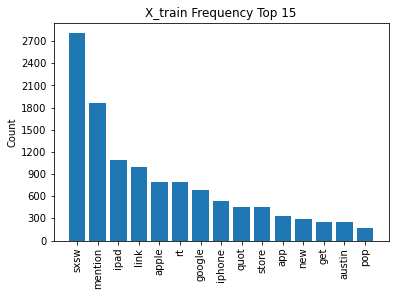

In [26]:
# plotting frequency distribution - plot of Training tokens top 15
train_freq_dist = FreqDist(X_train['Tweet_tokens'].explode())
plot_frequency(train_freq_dist, "X_train Frequency Top 15")

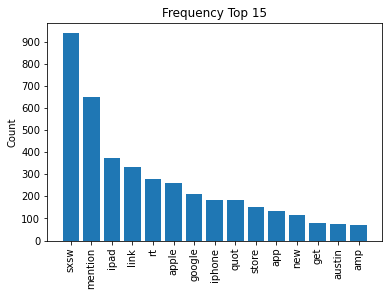

In [27]:
X_testfreq_dist = FreqDist(X_test['Tweet_tokens'].explode())
plot_frequency(X_testfreq_dist, "Frequency Top 15")

In [28]:
#secondary split for holdout set - final model will be evaluated on 
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train,
                                          test_size=0.25, random_state=42)

### CountVectorizer 
Running two separate Vectorizers, one restricted to 100 words and a second restricted to 2500. After modeling, it is clear that more words is equivalent to better performance. TF-IDF does seem to perform better than the CV method.

In [29]:
#CountVectorizer - limit to 100 words to check performance
#fit transform test data
cvec = CountVectorizer(max_features=100, stop_words=sw, strip_accents='ascii')
X_t_vec = cvec.fit_transform(X_t['tweet_text'])
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cvec.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)
X_t_vec

,also,amp,android,app,apple,apps,around,austin,awesome,begins,...,using,via,video,want,way,win,wins,would,wow,year
7411,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
157,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1762,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5059,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6344,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6746,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7233,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8256,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
#transform validation data
X_val_vec = cvec.transform(X_val['tweet_text'])
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cvec.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)
X_val_vec

,also,amp,android,app,apple,apps,around,austin,awesome,begins,...,using,via,video,want,way,win,wins,would,wow,year
2932,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5305,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3129,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3934,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3964,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2776,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1778,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1676,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
236,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
#rerun Vectorizer and limit down to 2500 features to check performance
#Fit transform training data
cv = CountVectorizer(max_features=2500, stop_words=sw, token_pattern=r"([a-zA-Z]+)", strip_accents='ascii')
X_train_cv = cv.fit_transform(X_t['tweet_text'])
X_train_cv  = pd.DataFrame.sparse.from_spmatrix(X_train_cv)
X_train_cv.columns = sorted(cv.vocabulary_)
X_train_cv.set_index(y_t.index, inplace=True)
X_train_cv

,aapl,abacus,able,abt,abuzz,accessory,accordion,account,aclu,acquired,...,zazzle,zazzlesxsw,zazzlsxsw,zero,zimride,zing,zite,zms,zombies,zomg
7411,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
157,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1762,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5059,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6344,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6746,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7233,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8256,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
#Transform validation data (testing)
X_val_cv = cv.transform(X_val['tweet_text'])
X_val_cv = pd.DataFrame.sparse.from_spmatrix(X_val_cv)
X_val_cv.columns = sorted(cv.vocabulary_)
X_val_cv.set_index(y_val.index, inplace=True)
X_val_cv 

,aapl,abacus,able,abt,abuzz,accessory,accordion,account,aclu,acquired,...,zazzle,zazzlesxsw,zazzlsxsw,zero,zimride,zing,zite,zms,zombies,zomg
2932,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5305,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3129,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3934,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3964,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1778,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1676,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
236,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### TF-IDF Vectorizer 
Unrestricted vocabulary tokenization of training and testing tweets for modeling. 

In [33]:
tfidf = TfidfVectorizer(stop_words=sw, lowercase=True, token_pattern=r"([a-zA-Z]+)", strip_accents='ascii')

X_t_tf = tfidf.fit_transform(X_t['tweet_text'])
X_t_tf  = pd.DataFrame.sparse.from_spmatrix(X_t_tf)
X_t_tf.columns = sorted(tfidf.vocabulary_)
X_t_tf.set_index(y_t.index, inplace=True)
X_t_tf

,aTM,aapl,abacus,abandoned,aber,able,abroad,absolutely,abt,abuzz,...,zazzlsxsw,zero,zimride,zing,zite,zms,zombies,zomg,zoom,zzzs
7411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
X_val_tf = tfidf.transform(X_val['tweet_text'])
X_val_tf  = pd.DataFrame.sparse.from_spmatrix(X_val_tf)
X_val_tf.columns = sorted(tfidf.vocabulary_)
X_val_tf.set_index(y_val.index, inplace=True)
X_val_tf

,aTM,aapl,abacus,abandoned,aber,able,abroad,absolutely,abt,abuzz,...,zazzlsxsw,zero,zimride,zing,zite,zms,zombies,zomg,zoom,zzzs
2932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
#Secondary TF-IDF vectorizer with new params to limit vocab to syntactically valuable words
tfidf2 = TfidfVectorizer(stop_words=sw, min_df= 0.002, lowercase=True, token_pattern=r'([a-z]{3,})', strip_accents='ascii')

X_train_tfidf = tfidf2.fit_transform(X_t['tweet_text'])
X_train_tfidf  = pd.DataFrame.sparse.from_spmatrix(X_train_tfidf)
X_train_tfidf.columns = sorted(tfidf2.vocabulary_)
X_train_tfidf.set_index(y_t.index, inplace=True)
X_train_tfidf

,aapl,able,aclu,acquired,action,actually,added,agree,airport,almost,...,years,yelp,yes,yesterday,yet,youa,youtube,yrs,zazzlesxsw,zomg
7411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.319443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
#transform validation data
X_val_tfidf = tfidf2.transform(X_val['tweet_text'])
X_val_tfidf  = pd.DataFrame.sparse.from_spmatrix(X_val_tfidf)
X_val_tfidf.columns = sorted(tfidf2.vocabulary_)
X_val_tfidf.set_index(y_val.index, inplace=True)
X_val_tfidf

,aapl,able,aclu,acquired,action,actually,added,agree,airport,almost,...,years,yelp,yes,yesterday,yet,youa,youtube,yrs,zazzlesxsw,zomg
2932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
#Summed weight of the TF-IDF Vectorized Matrix Features
tfidf_test = X_t_tf.sum()
type(tfidf_test)

pandas.core.series.Series

In [38]:
#To a DF
tf_df = pd.DataFrame(tfidf_test)
tf_df.rename(columns={0: 'Value'}, inplace=True)
tf_df

,Value
aTM,0.370153
aapl,2.374962
abacus,0.674593
abandoned,0.395082
aber,0.365554
...,...
zms,0.390987
zombies,0.750470
zomg,1.968308
zoom,0.281407


In [39]:
#Sorted
tf_df.sort_values('Value', ascending=False).tail(250)

,Value
ftp,0.315975
skype,0.315975
school,0.315350
magnetic,0.315350
brilliance,0.315350
...,...
gratification,0.258512
card,0.258512
survey,0.258512
nfusion,0.243972


## Modeling - Binary Classification

### Multinomial Bayes Models

##### Top Performing Naive Bayes Model - 'mnb3'
 *  Model was evaluated on CountVectorized Data restricted to a 2500 word vocabulary. 
     * Precision Score: 86%
     * Accuracy Score: 85%

In [40]:
#CountVect limited to 100 words
mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)

MultinomialNB()

In [41]:
#prior probabilities by label
prior_1 = y_t.value_counts()[1]/len(y_t)
prior_0 = y_t.value_counts()[0]/len(y_t)
print(prior_0, prior_1)

0.1568922305764411 0.8431077694235589


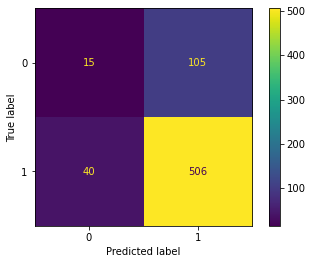

In [42]:
from sklearn.metrics import accuracy_score, precision_score, plot_confusion_matrix
plot_confusion_matrix(mnb, X_val_vec, y_val);

In [43]:
mnb.score(X_val_vec, y_val)

0.7822822822822822

In [44]:
y_hat3 = mnb.predict(X_val_vec)
print('Precision Score:', precision_score(y_val, y_hat3))
print('Accuracy Score:', accuracy_score(y_val, y_hat3))

Precision Score: 0.8281505728314239
Accuracy Score: 0.7822822822822822


In [45]:
#TFIDF unrestricted
mnb2 = MultinomialNB()

mnb2.fit(X_t_tf, y_t)

MultinomialNB()

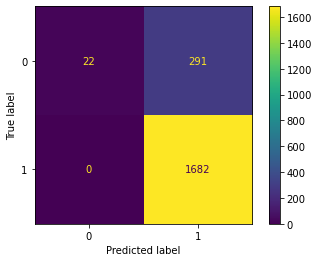

In [46]:
plot_confusion_matrix(mnb2,X_t_tf, y_t);

In [47]:
mnb2.score(X_val_tf, y_val)

0.8258258258258259

In [48]:
y_hat2 = mnb2.predict(X_val_tf)
print('Precision Score:', precision_score(y_val, y_hat2))
print('Accuracy Score:', accuracy_score(y_val, y_hat2))

Precision Score: 0.824773413897281
Accuracy Score: 0.8258258258258259


In [49]:
#CountVect limited to 2500
mnb3 = MultinomialNB()
mnb3.fit(X_train_cv, y_t)

MultinomialNB()

In [50]:
mnb3.score(X_train_cv, y_t)

0.9343358395989975

In [51]:
mnb3.score(X_val_cv, y_val)

0.8453453453453453

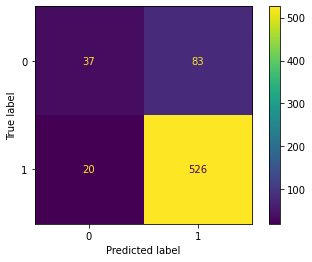

In [52]:
plot_confusion_matrix(mnb3, X_val_cv, y_val);

In [53]:
y_hat = mnb3.predict(X_val_cv)
print('Precision Score:', precision_score(y_val, y_hat))
print('Accuracy Score:', accuracy_score(y_val, y_hat))

Precision Score: 0.8637110016420362
Accuracy Score: 0.8453453453453453


In [54]:
#TF-IDF restricted to min_df params
mnb_tf = MultinomialNB()
mnb_tf.fit(X_train_tfidf, y_t)

MultinomialNB()

In [55]:
mnb_tf.score(X_train_tfidf, y_t)

0.8671679197994987

In [56]:
mnb_tf.score(X_val_tfidf, y_val)

0.8363363363363363

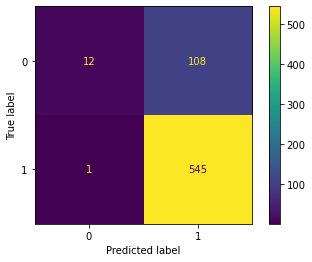

In [57]:
plot_confusion_matrix(mnb_tf, X_val_tfidf, y_val);

In [58]:
y_hat_tf = mnb_tf.predict(X_val_tfidf)
print('Precision Score:', precision_score(y_val, y_hat_tf))
print('Accuracy Score:', accuracy_score(y_val, y_hat_tf))

Precision Score: 0.8346094946401225
Accuracy Score: 0.8363363363363363


## Decision Trees 

##### Top Performing Decision Tree Model - 'dt2'
 *  Model was evaluated on TF-IDF Vectorized Data restricted to an 835 word vocabulary. 
     * Precision Score: 87%
     * Accuracy Score: 82%

In [59]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, plot_roc_curve, plot_confusion_matrix

#Training
dt1 = DecisionTreeClassifier()
dt1.fit(X_t_tf, y_t)

DecisionTreeClassifier()

In [60]:
dt1.score(X_t_tf, y_t)

1.0

In [61]:
dt_y_pred = dt1.predict(X_val_tf)
dt_y_pred

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [62]:
acc = accuracy_score(y_val, dt_y_pred) * 100
print("Accuracy: {0}".format(acc))
print("Precision:", (precision_score(y_val, dt_y_pred)*100))

Accuracy: 81.68168168168168
Precision: 87.19298245614036


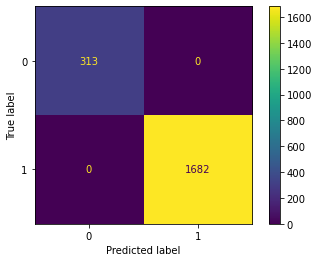

In [63]:
plot_confusion_matrix(dt1, X_t_tf, y_t);

In [64]:
dt1.score(X_val_tf, y_val)

0.8168168168168168

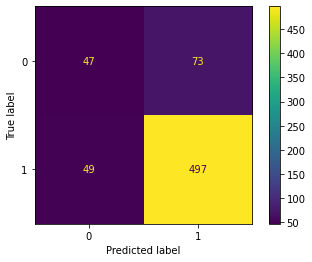

In [65]:
plot_confusion_matrix(dt1, X_val_tf, y_val);

In [66]:
#DecisionTree with restricted TF-IDF vocab using min_df param
dt2 = DecisionTreeClassifier()
dt2.fit(X_train_tfidf, y_t)

DecisionTreeClassifier()

In [67]:
dt2.score(X_train_tfidf, y_t)

0.9994987468671679

In [68]:
dt2.score(X_val_tfidf, y_val)

0.8213213213213213

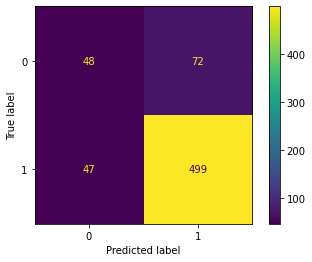

In [69]:
plot_confusion_matrix(dt2, X_val_tfidf, y_val);

In [70]:
print('Precision Score:', precision_score(y_val, dt2.predict(X_val_tfidf)))
print('Accuracy Score:', accuracy_score(y_val, dt2.predict(X_val_tfidf)))

Precision Score: 0.8739054290718039
Accuracy Score: 0.8213213213213213



### Random Forest Models

##### Top Performing Random Forest Model - 'rf_tfidf'
 * Final Assessed Random Forest has best Precision Score. Model was evaluated on TF-IDF Vectorized Data restricted to an 835 word vocabulary. Unrestricted TF-IDF vocabulary yielded VERY similar results, sacrificing less than a percent in Precision for less than a half a percent gain in Accuracy.
     * Precision Score: 86%
     * Accuracy Score: 85%

In [71]:
#TFIDF unrestricted vocab
rf = RandomForestClassifier(random_state=42)
rf.fit(X_t_tf, y_t)

RandomForestClassifier(random_state=42)

In [72]:
rf.score(X_t_tf, y_t)

1.0

In [73]:
rf.score(X_val_tf, y_val)
rf_y_hat1 = rf.predict(X_val_tf)
print('Precision Score:', precision_score(y_val, rf_y_hat1))
print('Accuracy Score:', accuracy_score(y_val, rf_y_hat1))

Precision Score: 0.8526645768025078
Accuracy Score: 0.8558558558558559


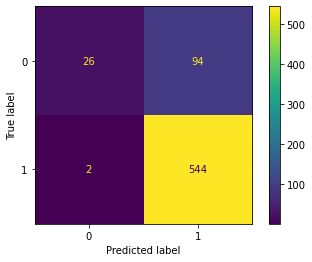

In [74]:
plot_confusion_matrix(rf,X_val_tf, y_val);

In [75]:
from sklearn.model_selection import GridSearchCV

In [76]:
# rf_grid = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [1, 2, 3, 5],
#     'min_samples_leaf' : [1, 5, 10, 25]
# }

# rf_gs = GridSearchCV(rf, rf_grid, cv=5)

In [77]:
# rf_gs.fit(X_t_tf, y_t)

In [78]:
# rf_gs.best_params_

In [79]:
# rf_gs.best_score_

In [80]:
# Count Vectorizer with 100 vocab
rf2 = RandomForestClassifier(random_state=42)
rf2.fit(X_t_vec, y_t)

RandomForestClassifier(random_state=42)

In [81]:
rf2.score(X_t_vec, y_t)

0.9754385964912281

In [82]:
rf2.score(X_val_vec, y_val)
rf_y_hat2 = rf2.predict(X_val_vec)
print('Precision Score:', precision_score(y_val, rf_y_hat2))
print('Accuracy Score:', accuracy_score(y_val, rf_y_hat2))

Precision Score: 0.8447412353923205
Accuracy Score: 0.8003003003003003


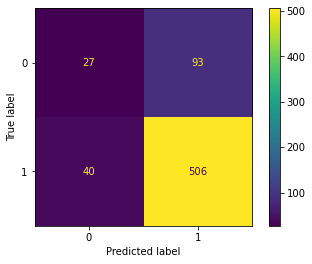

In [83]:
plot_confusion_matrix(rf2,X_val_vec, y_val);

In [84]:
#CountVect with 2500 words
rf3 = RandomForestClassifier(random_state=42)
rf3.fit(X_train_cv, y_t)

RandomForestClassifier(random_state=42)

In [85]:
rf3.score(X_train_cv, y_t)

1.0

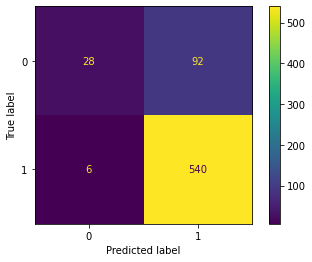

In [86]:
plot_confusion_matrix(rf3,X_val_cv, y_val);

In [87]:
#performance increases by about 5%
rf3.score(X_val_cv, y_val)
rf_y_hat3 = rf3.predict(X_val_cv)
print('Precision Score:', precision_score(y_val, rf_y_hat3))
print('Accuracy Score:', accuracy_score(y_val, rf_y_hat3))

Precision Score: 0.8544303797468354
Accuracy Score: 0.8528528528528528


In [88]:
#RandomForest with restricted TF-IDF vocab
rf_tfidf = RandomForestClassifier()
rf_tfidf.fit(X_train_tfidf, y_t)

RandomForestClassifier()

In [89]:
rf_tfidf.score(X_train_tfidf, y_t)

0.9994987468671679

In [90]:
rf_tfidf.score(X_val_tfidf, y_val)

0.8483483483483484

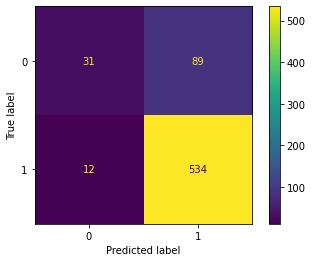

In [91]:
plot_confusion_matrix(rf_tfidf, X_val_tfidf, y_val);

In [92]:
rf_y_hattf = rf_tfidf.predict(X_val_tfidf)
print('Precision Score:', precision_score(y_val, rf_y_hattf))
print('Accuracy Score:', accuracy_score(y_val, rf_y_hattf))

Precision Score: 0.8571428571428571
Accuracy Score: 0.8483483483483484


### KNN Models

##### Top Performing KNN Model 
 * Initial KNN Model had best metrics. Performed on CountVectorized Data with 2500 word vocabulary.
     * Accuracy 83%
     * Precision 87%

In [93]:
from sklearn.neighbors import KNeighborsClassifier

In [94]:
#Count Vect 2500 vocab
knn = KNeighborsClassifier()
knn.fit(X_train_cv, y_t)

KNeighborsClassifier()

In [95]:
knn.score(X_train_cv, y_t)

0.8947368421052632

In [96]:
knn.score(X_val_cv, y_val)

0.8288288288288288

In [97]:
knn_y_hat = knn.predict(X_val_cv)
print('Precision Score:', precision_score(y_val, knn_y_hat))
print('Accuracy Score:', accuracy_score(y_val, knn_y_hat))

Precision Score: 0.8673469387755102
Accuracy Score: 0.8288288288288288


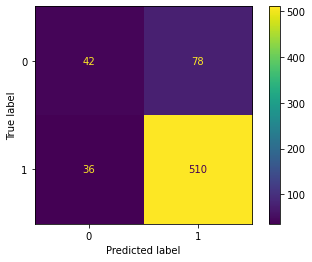

In [98]:
plot_confusion_matrix(knn, X_val_cv, y_val);

In [99]:
#TFIDF unrestricted
knn2 = KNeighborsClassifier()
knn2.fit(X_t_tf, y_t)

KNeighborsClassifier()

In [100]:
knn2.score(X_t_tf, y_t)

0.8822055137844611

In [101]:
knn2.score(X_val_tf, y_val)

0.8348348348348348

In [102]:
knn_y_hat2 = knn2.predict(X_val_tf)
print('Precision Score:', precision_score(y_val, knn_y_hat2))
print('Accuracy Score:', accuracy_score(y_val, knn_y_hat2))

Precision Score: 0.8482428115015974
Accuracy Score: 0.8348348348348348


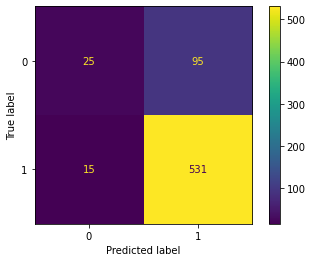

In [103]:
plot_confusion_matrix(knn2, X_val_tf, y_val);

In [104]:
#Count Vect 100 vocab - NO BUENO. MAS ES MEJOR.
knn3 = KNeighborsClassifier()
knn3.fit(X_t_vec, y_t)

KNeighborsClassifier()

In [105]:
knn3.score(X_t_vec, y_t)

0.8666666666666667

In [106]:
knn3.score(X_val_vec, y_val)

0.7867867867867868

In [107]:
knn_y_hat3 = knn3.predict(X_val_vec)
print('Precision Score:', precision_score(y_val, knn_y_hat3))
print('Accuracy Score:', accuracy_score(y_val, knn_y_hat3))

Precision Score: 0.8447098976109215
Accuracy Score: 0.7867867867867868


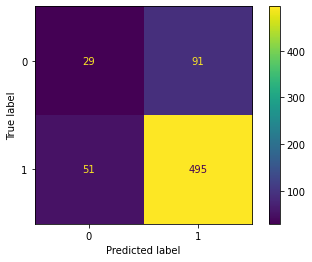

In [108]:
plot_confusion_matrix(knn3, X_val_vec, y_val);

In [109]:
knn_last = KNeighborsClassifier()
knn_last.fit(X_train_tfidf, y_t)

KNeighborsClassifier()

In [110]:
knn_last.score(X_train_tfidf, y_t)

0.8847117794486216

In [111]:
knn_last.score(X_val_tfidf, y_val)

0.8228228228228228

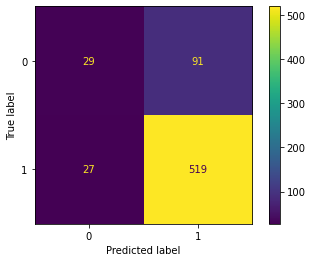

In [112]:
plot_confusion_matrix(knn_last, X_val_tfidf, y_val);

In [113]:
knn_last_yhat = knn_last.predict(X_val_tfidf)
print('Precision Score:', precision_score(y_val, knn_last_yhat))
print('Accuracy Score:', accuracy_score(y_val, knn_last_yhat))

Precision Score: 0.8508196721311475
Accuracy Score: 0.8228228228228228


## Final Results

#### Given the above best performing models and metrics, hold out dataset to be fed into the Naive Bayes and the RandomForest models for final scores and evaluation.

##### Multinomial Naive Bayes Final Performance - 'mnb3' - Optimal Performance above on CV2500
    * Final Accuracy - 85.23 %
    * Final Precision - 87.98 %

##### RandomForest Final Performance - 'rf_tfidf' - Optimal Performance above on TF-IDF835
    * Final Accuracy - 87.94 %
    * Final Precision - 88.23 %
    
### See Twitter Iteration Section for additional iterations with removal of Twitter specific stop words.

In [114]:
#transform holdout data for modeling - optimal performing models used CV2500 and TF-IDF835
#CountVectorizer 2500 word vocab test for Bayes Modeling
Xtest_cv = cv.transform(X_test['tweet_text'])
Xtest_cv = pd.DataFrame.sparse.from_spmatrix(Xtest_cv)
Xtest_cv.columns = sorted(cv.vocabulary_)
Xtest_cv.set_index(y_test.index, inplace=True)
Xtest_cv

,aapl,abacus,able,abt,abuzz,accessory,accordion,account,aclu,acquired,...,zazzle,zazzlesxsw,zazzlsxsw,zero,zimride,zing,zite,zms,zombies,zomg
685,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6393,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7851,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5813,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2944,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2657,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
233,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3929,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [115]:
bayes_hat = mnb3.predict(Xtest_cv)
print('Precision Score:', precision_score(y_test, bayes_hat)*100)
print('Accuracy Score:', accuracy_score(y_test, bayes_hat)*100)

Precision Score: 87.97546012269939
Accuracy Score: 85.23111612175873


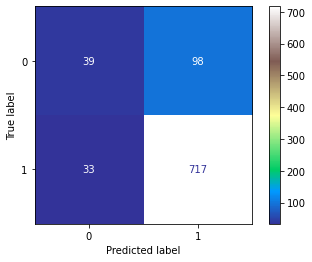

In [116]:
plot_confusion_matrix(mnb3, Xtest_cv, y_test, cmap='terrain');

In [117]:
#transform holdout data for modeling - optimal performing models used CV2500 and TF-IDF835
#TF-IDF Vectorizer 835 word vocab for RandomForest Modeling
Xtest_tfidf = tfidf2.transform(X_test['tweet_text'])
Xtest_tfidf = pd.DataFrame.sparse.from_spmatrix(Xtest_tfidf)
Xtest_tfidf.columns = sorted(tfidf2.vocabulary_)
Xtest_tfidf.set_index(y_test.index, inplace=True)
Xtest_tfidf

,aapl,able,aclu,acquired,action,actually,added,agree,airport,almost,...,years,yelp,yes,yesterday,yet,youa,youtube,yrs,zazzlesxsw,zomg
685,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2657,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
forest_hat = rf_tfidf.predict(Xtest_tfidf)
print('Precision Score:', precision_score(y_test, forest_hat)*100)
print('Accuracy Score:', accuracy_score(y_test, forest_hat)*100)

Precision Score: 88.18615751789977
Accuracy Score: 87.59864712514093


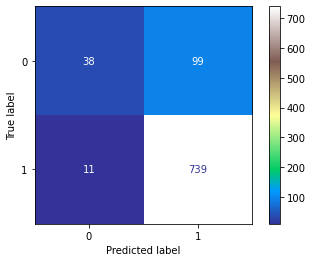

In [119]:
plot_confusion_matrix(rf_tfidf, Xtest_tfidf, y_test, cmap='terrain');

In [120]:
rf_feat_import = {name: score 
                   for name, score 
                       in zip(Xtest_tfidf.columns, rf_tfidf.feature_importances_)
}
rf_feat_import = pd.DataFrame(data=rf_feat_import, index=range(len(rf_feat_import)))
rf_feat_import.head()

,aapl,able,aclu,acquired,action,actually,added,agree,airport,almost,...,years,yelp,yes,yesterday,yet,youa,youtube,yrs,zazzlesxsw,zomg
0,0.000001,0.000083,0.000035,0.000504,0.000234,0.000026,0.001498,0.000127,0.000052,0.000975,...,0.006194,6.093916e-07,0.001168,0.000674,0.004299,0.000058,0.000299,9.949787e-08,0.000021,0.000053
1,0.000001,0.000083,0.000035,0.000504,0.000234,0.000026,0.001498,0.000127,0.000052,0.000975,...,0.006194,6.093916e-07,0.001168,0.000674,0.004299,0.000058,0.000299,9.949787e-08,0.000021,0.000053
2,0.000001,0.000083,0.000035,0.000504,0.000234,0.000026,0.001498,0.000127,0.000052,0.000975,...,0.006194,6.093916e-07,0.001168,0.000674,0.004299,0.000058,0.000299,9.949787e-08,0.000021,0.000053
3,0.000001,0.000083,0.000035,0.000504,0.000234,0.000026,0.001498,0.000127,0.000052,0.000975,...,0.006194,6.093916e-07,0.001168,0.000674,0.004299,0.000058,0.000299,9.949787e-08,0.000021,0.000053
4,0.000001,0.000083,0.000035,0.000504,0.000234,0.000026,0.001498,0.000127,0.000052,0.000975,...,0.006194,6.093916e-07,0.001168,0.000674,0.004299,0.000058,0.000299,9.949787e-08,0.000021,0.000053


In [121]:
#drop duplicates and transpose view
rf_feat_import.drop_duplicates(inplace=True)
rf_feat_import = rf_feat_import.T
rf_feat_import

,0
aapl,1.437438e-06
able,8.317483e-05
aclu,3.456747e-05
acquired,5.036317e-04
action,2.342776e-04
...,...
youa,5.811120e-05
youtube,2.987945e-04
yrs,9.949787e-08
zazzlesxsw,2.080992e-05


In [122]:
#rename column and sort to top 10 features
rf_feat_import.rename(columns = {0: 'Importance'}, inplace = True)
rf_feat_import.sort_values(by='Importance', ascending=False, inplace=True)
rf_feat_import.head(10)

,Importance
sxsw,0.030482
link,0.023842
mention,0.017676
ipad,0.016497
google,0.015245
quot,0.014321
headaches,0.013766
iphone,0.012982
fail,0.012685
people,0.011235


In [123]:
#curious to see how the RF does on the CV2500 test data as well - using the rf3 fit to this data above.
#Not as well. Final model is the RF on the restricted TF-IDF data!
curious_hat = rf3.predict(Xtest_cv)
print('Precision Score:', precision_score(y_test, curious_hat)*100)
print('Accuracy Score:', accuracy_score(y_test, curious_hat)*100)

Precision Score: 88.08104886769964
Accuracy Score: 87.4859075535513


# Twitter Specific Language Iteration Revisions
## Iterating through additional Models with removal of Twitter Specific Stopwords

##### Unsure of value of hashtag or tweet specific language. Adding to secondary stopwords list and running models separately to check performance again for exhaustability.

In [124]:
#Append ('link', 'mention', 'quot', 'sxsw') to stop words list for removal from vocab
sw2 = stopwords.words('english')
sw2.append('link')

In [125]:
sw2.append('mention')

In [126]:
sw2.append('quot')

In [127]:
sw2.append('sxsw')
print(sw2)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### CountVectorizer - 2500 Word Vocab less Twitter-specific vocab for analysis
From above analysis, limiting CountVect to 2500 word vocab for Twitter-specific stopword removal.

In [128]:
cv3 = CountVectorizer(max_features=2500, stop_words=sw2, token_pattern=r"([a-zA-Z]+)", strip_accents='ascii')

X_train_cv3 = cv3.fit_transform(X_t['tweet_text'])
X_train_cv3  = pd.DataFrame.sparse.from_spmatrix(X_train_cv3)
X_train_cv3.columns = sorted(cv3.vocabulary_)
X_train_cv3.set_index(y_t.index, inplace=True)
X_train_cv3

,aapl,abacus,able,abt,abuzz,accessory,accordion,account,aclu,acquired,...,zazzle,zazzlesxsw,zazzlsxsw,zero,zimride,zing,zite,zms,zombies,zomg
7411,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
157,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1762,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5059,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6344,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6746,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7233,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8256,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [129]:
X_val_cv3 = cv3.transform(X_val['tweet_text'])
X_val_cv3  = pd.DataFrame.sparse.from_spmatrix(X_val_cv3)
X_val_cv3.columns = sorted(cv3.vocabulary_)
X_val_cv3.set_index(y_val.index, inplace=True)
X_val_cv3

,aapl,abacus,able,abt,abuzz,accessory,accordion,account,aclu,acquired,...,zazzle,zazzlesxsw,zazzlsxsw,zero,zimride,zing,zite,zms,zombies,zomg
2932,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5305,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3129,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3934,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3964,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1778,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1676,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
236,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [130]:
X_test_cv3 = cv3.transform(X_test['tweet_text'])
X_test_cv3  = pd.DataFrame.sparse.from_spmatrix(X_test_cv3)
X_test_cv3.columns = sorted(cv3.vocabulary_)
X_test_cv3.set_index(y_test.index, inplace=True)
X_test_cv3

,aapl,abacus,able,abt,abuzz,accessory,accordion,account,aclu,acquired,...,zazzle,zazzlesxsw,zazzlsxsw,zero,zimride,zing,zite,zms,zombies,zomg
685,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6393,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7851,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5813,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2944,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2657,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
233,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3929,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### TF-IDF Unrestricted and 835 Restricted Vocabs - Less the Twitter-Specific Stopwords

In [131]:
tfidf_rest = TfidfVectorizer(stop_words=sw2, min_df= 0.002, lowercase=True, token_pattern=r'([a-z]{3,})', strip_accents='ascii')

X_train_tfidf_rest = tfidf_rest.fit_transform(X_t['tweet_text'])
X_train_tfidf_rest = pd.DataFrame.sparse.from_spmatrix(X_train_tfidf_rest)
X_train_tfidf_rest.columns = sorted(tfidf_rest.vocabulary_)
X_train_tfidf_rest.set_index(y_t.index, inplace=True)
X_train_tfidf_rest

,aapl,able,aclu,acquired,action,actually,added,agree,airport,almost,...,years,yelp,yes,yesterday,yet,youa,youtube,yrs,zazzlesxsw,zomg
7411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.321404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [132]:
X_val_tfidf_rest = tfidf_rest.transform(X_val['tweet_text'])
X_val_tfidf_rest = pd.DataFrame.sparse.from_spmatrix(X_val_tfidf_rest)
X_val_tfidf_rest.columns = sorted(tfidf_rest.vocabulary_)
X_val_tfidf_rest.set_index(y_val.index, inplace=True)
X_val_tfidf_rest

,aapl,able,aclu,acquired,action,actually,added,agree,airport,almost,...,years,yelp,yes,yesterday,yet,youa,youtube,yrs,zazzlesxsw,zomg
2932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [133]:
total_tfidf = TfidfVectorizer(stop_words=sw2, lowercase=True, token_pattern=r'([a-z]{3,})', strip_accents='ascii')

X_train_tfidf_total = total_tfidf.fit_transform(X_t['tweet_text'])
X_train_tfidf_total = pd.DataFrame.sparse.from_spmatrix(X_train_tfidf_total)
X_train_tfidf_total.columns = sorted(total_tfidf.vocabulary_)
X_train_tfidf_total.set_index(y_t.index, inplace=True)
X_train_tfidf_total

,aapl,abacus,abandoned,aber,able,abroad,absolutely,abt,abuzz,academy,...,zazzlsxsw,zero,zimride,zing,zite,zms,zombies,zomg,zoom,zzzs
7411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [134]:
X_val_tfidf_total = total_tfidf.transform(X_val['tweet_text'])
X_val_tfidf_total = pd.DataFrame.sparse.from_spmatrix(X_val_tfidf_total)
X_val_tfidf_total.columns = sorted(total_tfidf.vocabulary_)
X_val_tfidf_total.set_index(y_val.index, inplace=True)
X_val_tfidf_total

,aapl,abacus,abandoned,aber,able,abroad,absolutely,abt,abuzz,academy,...,zazzlsxsw,zero,zimride,zing,zite,zms,zombies,zomg,zoom,zzzs
2932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
#transform final holdout for analysis
X_test_total_tfidf = total_tfidf.transform(X_test['tweet_text'])
X_test_total_tfidf = pd.DataFrame.sparse.from_spmatrix(X_test_total_tfidf)
X_test_total_tfidf.columns = sorted(total_tfidf.vocabulary_)
X_test_total_tfidf.set_index(y_test.index, inplace=True)
X_test_total_tfidf

,aapl,abacus,abandoned,aber,able,abroad,absolutely,abt,abuzz,academy,...,zazzlsxsw,zero,zimride,zing,zite,zms,zombies,zomg,zoom,zzzs
685,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2657,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
X_test_tfidf_rest = tfidf_rest.transform(X_test['tweet_text'])
X_test_tfidf_rest = pd.DataFrame.sparse.from_spmatrix(X_test_tfidf_rest)
X_test_tfidf_rest.columns = sorted(tfidf_rest.vocabulary_)
X_test_tfidf_rest.set_index(y_test.index, inplace=True)
X_test_tfidf_rest

,aapl,able,aclu,acquired,action,actually,added,agree,airport,almost,...,years,yelp,yes,yesterday,yet,youa,youtube,yrs,zazzlesxsw,zomg
685,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2657,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Modeling

### Remodel and Check Performance on Top Performing Models Above

Checking performance only on top performers above at this time due to time constraints.

##### Multinomial Bayes performs similarly here without the Twitter Stopwords using CountVect with 2500 word Vocab.
    * Final Precision: 88.45%
    * Final Accuracy: 86%


##### RandomForest with unrestricted performs almost identically as the previous models without the Twitter Stopwords.
    * Final Precision: 88.26%
    * Final Accuracy: 88.16%

##### RandomForest with restricted vocab performs slightly worse in terms of accuracy without the Twitter Stopwords compared to it's unrestricted counterpart.
    * Final Precision: 88.26%
    * Final Accuracy: 87.49%
    
##### KNN Evaluated again as sanity check. Performs about the same comparatively to the previous KNN model, a bit better in terms of accuracy.
    * Final Precision: ~ 87%
    * Final Accuracy: 84%
    

### Multinomial Naive Bayes

In [137]:
#Fit to CountVect Data - 2500 words
bayes = MultinomialNB()
bayes.fit(X_train_cv3, y_t)

MultinomialNB()

In [138]:
bayes.score(X_train_cv3, y_t)

0.9393483709273183

In [139]:
bayes.score(X_val_cv3, y_val)

0.8423423423423423

In [140]:
#validation data
bayes_iter_hat = bayes.predict(X_val_cv3)
print('Validation Precision Score:', precision_score(y_val, bayes_iter_hat)*100)
print('Validation Accuracy Score:', accuracy_score(y_val, bayes_iter_hat)*100)

Validation Precision Score: 86.44628099173553
Validation Accuracy Score: 84.23423423423422


In [141]:
#testing holdout data
bayes_test_hat = bayes.predict(X_test_cv3)
print('Test Precision Score:', precision_score(y_test, bayes_test_hat)*100)
print('Test Accuracy Score:', accuracy_score(y_test, bayes_test_hat)*100)

Test Precision Score: 88.45208845208845
Test Accuracy Score: 86.02029312288614


In [142]:
bayes.fit(X_train_tfidf_rest, y_t)

MultinomialNB()

In [143]:
#validation data - TF-IDF restricted - 831 words
bayes.score(X_val_tfidf_rest, y_val)

0.8393393393393394

In [144]:
#testing holdout data -TF-IDF restricted performs better than total on Bayes
bayes_rest_hat = bayes.predict(X_test_tfidf_rest)
print('Precision Score:', precision_score(y_test, bayes_rest_hat)*100)
print('Accuracy Score:', accuracy_score(y_test, bayes_rest_hat)*100)

Precision Score: 85.48571428571428
Accuracy Score: 85.456595264938


### RandomForest

In [145]:
#restricted TF-IDF Vocab
forest = RandomForestClassifier(random_state=42)
forest.fit(X_train_tfidf_rest, y_t)

RandomForestClassifier(random_state=42)

In [146]:
forest.score(X_train_tfidf_rest, y_t)

0.9969924812030075

In [147]:
forest.score(X_val_tfidf_rest, y_val)

0.8468468468468469

In [148]:
forest_iter_hat = forest.predict(X_val_tfidf_rest)
print('Validation Precision Score:', precision_score(y_val, forest_iter_hat)*100)
print('Validation Accuracy Score:', accuracy_score(y_val, forest_iter_hat)*100)

Validation Precision Score: 86.03896103896103
Validation Accuracy Score: 84.68468468468468


In [149]:
forest_rest = forest.predict(X_test_tfidf_rest)
print('Test Precision Score:', precision_score(y_test, forest_rest)*100)
print('Test Accuracy Score:', accuracy_score(y_test, forest_rest)*100)

Test Precision Score: 88.26347305389221
Test Accuracy Score: 87.4859075535513


In [150]:
#unrestricted TF-IDF - 4150 words
forest_total = RandomForestClassifier(random_state=5)
forest_total.fit(X_train_tfidf_total, y_t)

RandomForestClassifier(random_state=5)

In [151]:
forest_total.score(X_train_tfidf_total, y_t)

0.9994987468671679

In [152]:
forest_total.score(X_val_tfidf_total, y_val)

0.8633633633633634

In [153]:
forest_iter_hat2 = forest_total.predict(X_val_tfidf_total)
print('Validation Precision Score:', precision_score(y_val, forest_iter_hat2)*100)
print('Validation Accuracy Score:', accuracy_score(y_val, forest_iter_hat2)*100)

Validation Precision Score: 86.16852146263912
Validation Accuracy Score: 86.33633633633634


In [154]:
rf_feat_iter = {name: score 
                   for name, score 
                       in zip(X_test_total_tfidf.columns, forest_total.feature_importances_)
}
rf_feat_iter = pd.DataFrame(data=rf_feat_iter, index=range(len(rf_feat_iter)))
rf_feat_iter.head()

,aapl,abacus,abandoned,aber,able,abroad,absolutely,abt,abuzz,academy,...,zazzlsxsw,zero,zimride,zing,zite,zms,zombies,zomg,zoom,zzzs
0,0.000007,0.000628,0.000517,0.0,0.00004,0.000469,0.00001,0.000047,0.00002,0.0,...,0.00002,0.0,0.0,0.0,0.0,0.0,0.000036,0.000018,0.0,0.000667
1,0.000007,0.000628,0.000517,0.0,0.00004,0.000469,0.00001,0.000047,0.00002,0.0,...,0.00002,0.0,0.0,0.0,0.0,0.0,0.000036,0.000018,0.0,0.000667
2,0.000007,0.000628,0.000517,0.0,0.00004,0.000469,0.00001,0.000047,0.00002,0.0,...,0.00002,0.0,0.0,0.0,0.0,0.0,0.000036,0.000018,0.0,0.000667
3,0.000007,0.000628,0.000517,0.0,0.00004,0.000469,0.00001,0.000047,0.00002,0.0,...,0.00002,0.0,0.0,0.0,0.0,0.0,0.000036,0.000018,0.0,0.000667
4,0.000007,0.000628,0.000517,0.0,0.00004,0.000469,0.00001,0.000047,0.00002,0.0,...,0.00002,0.0,0.0,0.0,0.0,0.0,0.000036,0.000018,0.0,0.000667


In [155]:
rf_feat_iter.drop_duplicates(inplace=True)
rf_feat_iter = rf_feat_iter.T
rf_feat_iter

,0
aapl,0.000007
abacus,0.000628
abandoned,0.000517
aber,0.000000
able,0.000040
...,...
zms,0.000000
zombies,0.000036
zomg,0.000018
zoom,0.000000


In [156]:
rf_feat_iter.rename(columns = {0: 'Importance'}, inplace = True)
rf_feat_iter.sort_values(by='Importance', ascending=False, inplace=True)
rf_feat_iter.head(10)

,Importance
fail,0.010283
headaches,0.010090
money,0.006893
ipad,0.006673
fascist,0.006606
fades,0.006560
apple,0.006423
long,0.006400
sucks,0.005849
hate,0.005725


In [157]:
final_forest = forest_total.predict(X_test_total_tfidf)
print('Test Precision Score:', precision_score(y_test, final_forest)*100)
print('Test Accuracy Score:', accuracy_score(y_test, final_forest)*100)

Test Precision Score: 88.25622775800713
Test Accuracy Score: 88.16234498308907


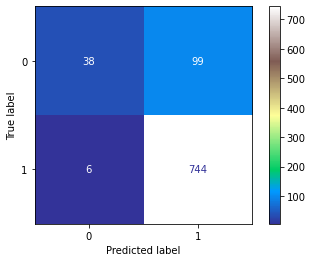

In [158]:
plot_confusion_matrix(forest_total, X_test_total_tfidf, y_test, cmap='terrain');

In [159]:
#check RF performance on CountVect 2500 vocab as well
rf3.fit(X_train_cv3, y_t)

RandomForestClassifier(random_state=42)

In [160]:
rf3.score(X_train_cv3, y_t)

0.9994987468671679

In [161]:
rf3.score(X_val_cv3, y_val)

0.8453453453453453

In [162]:
forest_cv_hat = rf3.predict(X_val_cv3)
print('Precision Score:', precision_score(y_val, forest_cv_hat)*100)
print('Accuracy Score:', accuracy_score(y_val, forest_cv_hat)*100)

Precision Score: 86.37110016420363
Accuracy Score: 84.53453453453453


### KNN 

In [163]:
#Check KNN performance on CV 2500 vocab
knn_cv = KNeighborsClassifier()
knn_cv.fit(X_train_cv3, y_t)

KNeighborsClassifier()

In [164]:
knn_cv.score(X_train_cv3, y_t)

0.8977443609022556

In [165]:
knn_cv.score(X_val_cv3, y_val)

0.8138138138138138

In [166]:
#KNN restricted performance - 831 words
knn_tf = KNeighborsClassifier()
knn_tf.fit(X_train_tfidf_rest, y_t)

KNeighborsClassifier()

In [167]:
knn_tf.score(X_train_tfidf_rest, y_t)

0.8867167919799499

In [168]:
knn_tf.score(X_val_tfidf_rest, y_val)

0.8363363363363363

In [169]:
knn_tf_hat = knn_tf.predict(X_test_tfidf_rest)
print('Test Precision Score:', precision_score(y_test, knn_tf_hat)*100)
print('Test Accuracy Score:', accuracy_score(y_test, knn_tf_hat)*100)

Test Precision Score: 86.92493946731234
Test Accuracy Score: 84.21645997745209


In [170]:
#KNN unrestricted TF-IDF performance - 4150 words
knn_tf.fit(X_train_tfidf_total, y_t)

KNeighborsClassifier()

In [171]:
knn_tf.score(X_train_tfidf_total, y_t)

0.8867167919799499

In [172]:
knn_tf.score(X_val_tfidf_total, y_val)

0.8333333333333334


<head>
    <title>  Further Analysis </title>
    <style>
      hr {
        idth: 100%;
        height: 30px;
        margin-left: auto;
        margin-right: auto;
        background-color: #b7d0e2;}
    </style>
  </head>
  <body>
    <h1><center>Further Analysis</center></h1>
    <hr />
  </body>
  
<p> <center> Worth exploring at a later date is adding the 'neutral sentiment' tweets back into the data for modeling and analysis. The data prep has been started below and is staged for modeling at a later time due to time and resource constraints. </center> </p>



## Modeling - MultiClass Classification

## Data Prep for Tertiary Modeling

In [173]:
df

,tweet_text,Directed At,Emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",Unknown,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",Unknown,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,Unknown,No emotion toward brand or product


In [174]:
#0 negative, 2 positive, 1 neutral
le = LabelEncoder()
df['Emotion'] = le.fit_transform(df['Emotion'])

In [175]:
#0 negative, 2 positive, 1 neutral
df.Emotion.value_counts(normalize=True)

1    0.602954
2    0.333259
0    0.063787
Name: Emotion, dtype: float64

In [176]:
multi_X = df.tweet_text
multi_y = df.Emotion

multi_X_train, multi_X_test, multi_y_train, multi_y_test = train_test_split(multi_X, multi_y, test_size=0.25, random_state=25)

In [177]:
multi_X_train = pd.DataFrame(multi_X_train)
multi_X_test = pd.DataFrame(multi_X_test)
multi_X_test

,tweet_text
5088,@mention on @mention apple iPad2 popup store @...
6591,RT @mention RT @mention New #UberSocial 4 #iPh...
5488,RT @mention Are you at #sxsw? Check out #Tokii...
3317,@mention Go #Android program: {link} (by @ment...
1203,I spotted three iPad 2's in just the first 10 ...
...,...
4442,12 billion miles a year driven with Google Nav...
4700,@mention not launching any products at #SXSW b...
8302,can't wait to see @mention on Friday at the #s...
6712,RT @mention Test Drive an Xperia Play with @me...


In [178]:
multi_X_train['Tweet_tokens'] = [tweet_preparer(tweet, sw) for tweet in multi_X_train['tweet_text']]

['google', 'real', 'time', 'location', 'data', 'layer', 'google', 'earth', 'gives', 'breathtaking', 'visual', 'data', 'sxsw']
['mention', 'check', 'bunch', 'free', 'atx', 'mention', 'unofficial', 'sxsw', 'events', 'list', 'iphone', 'android', 'link']
['first', 'line', 'morning', 'apple', 'pop', 'store', 'austin', 'mention', 'caught', 'mention', 'morning', 'link', 'sxsw']
['k', 'quot', 'high', 'quality', 'pdf', 'quot', 'ipad', 'app', 'good', 'investment', 'small', 'mags', 'says', 'chris', 'tomlinson', 'formerly', 'texas', 'obs', 'ap', 'sxsw']
['leaning', 'web', 'conventions', 'like', 'small', 'buttons', 'ipad', 'uxdes', 'sxsw']
['rt', 'mention', 'got', 'band', 'want', 'promote', 'come', 'say', 'hi', 'mention', 'team', 'google', 'party', 'maggiemaes', 'sxsw']
['rt', 'mention', 'sxsw', 'download', 'free', 'music', 'mix', 'itunes', 'link']
['rt', 'mention', 'hitlantis', 'ipad', 'cool', 'song', 'explorer', 'app', 'hitlantis', 'com', 'sxsw', 'musicviz']
['n', 'spreading', 'disease', 'link', 

['one', 'sxsw', 'panel', 'moderator', 'europe', 'says', 'spent', 'roaming', 'charges', 'iphone', 'sxsw']
['first', 'apps', 'download', 'ipad', 'link', 'sxsw', 'via', 'mention', 'mention']
['google', 'circles', 'looms', 'google', 'nerds', 'get', 'social', 'sxsw', 'mention', 'link']
['haha', 'guy', 'asking', 'marissagoogle', 'google', 'interview', 'questions', 'sxsw']
['rt', 'mention', 'following', 'mention', 'leanux', 'panel', 'sxsw', 'realtime', 'google', 'docs', 'link', 'thanks', 'mention']
['thinking', 'still', 'good', 'though', 'rt', 'mention', 'quot', 'google', 'tweet', 'new', 'think', 'speak', 'quot', 'belinsky', 'sxsw', 'via', 'mention']
['quot', 'google', 'canadian', 'tuxedo', 'lose', 'hours', 'quot', 'sxsw']
['making', 'sure', 'packed', 'everything', 'need', 'sxsw', 'iphone', 'ipad', 'chargers', 'business', 'cards', 'pants', 'missing', 'anything']
['sxsw', 'hotspots', 'klout', 'score', 'score', 'cluster', 'mention', 'mention', 'mashup', 'mention', 'mention', 'link']
['print', '

['rt', 'mention', 'debuting', 'new', 'iphone', 'amp', 'droid', 'app', 'sxsw', 'next', 'year', 'makes', 'phone', 'waterproof', 'amp', 'light', 'cigarettes']
['yeah', 'googlegays', 'get', 'sxswsex', 'mention', 'popular', 'gay', 'dating', 'app', 'grindr', 'android', 'link', 'grindr', 'sxsw']
['rt', 'mention', 'quot', 'ipad', 'dj', 'working', 'etsy', 'party', 'quot', 'realtalk', 'sxsw']
['rt', 'mention', 'new', 'ipad', 'apps', 'speech', 'therapy', 'communication', 'showcased', 'sxsw', 'mention', 'link']
['rt', 'mention', 'sxsw', 'guy', 'front', 'panel', 'ipad', 'etch', 'sketch', 'case', 'device', 'wonder', 'iusxsw']
['geeky', 'love', 'rt', 'mention', 'apple', 'opening', 'temporary', 'store', 'downtown', 'austin', 'sxsw', 'ipad', 'launch', 'link']
['rt', 'mention', 'sxsw', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'mention', 'link', 'via', 'mention']
['apple', 'pop', 'store', 'austin', 'sxsw', 'get', 'peeps', 'line', 'store', 'finishe

['nu', 'user', 'rt', 'mention', 'new', 'ubersocial', 'iphone', 'app', 'store', 'includes', 'uberguide', 'sxsw', 'sponsored', 'mashable']
['mention', 'think', 'might', 'quit', 'resume', 'tonight', 'ipad', 'iphone', 'tethering', 'happened', 'better', 'time', 'sxsw']
['rt', 'mention', 'th', 'congress', 'scarborough', 'bldg', 'rt', 'mention', 'temporary', 'apple', 'store', 'setup', 'sxsw']
['rt', 'mention', 'apple', 'opening', 'temporary', 'store', 'downtown', 'austin', 'sxsw', 'ipad', 'launch', 'link']
['link', 'edchat', 'musedchat', 'sxsw', 'sxswi', 'classical', 'newtwitter']
['sxsw', 'apple', 'schools', 'marketing', 'experts', 'link', 'apple', 'jobsco', 'sxsw']
['bout', 'time', 'rt', 'mention', 'new', 'ubersocial', 'iphone', 'app', 'store', 'includes', 'uberguide', 'sxsw', 'sponsored', 'cont', 'link']
['rt', 'mention', 'ppl', 'authoritzed', 'scrape', 'republish', 'pages', 'r', 'google', 'bing', 'bing', 'google', 'mention', 'qagb', 'sxsw']
['rt', 'mention', 'sxsw', 'bound', 'keep', 'eye'

['decided', 'need', 'ipad', 'usguys', 'sxsw']
['marissa', 'mayer', 'rechristening', 'augmented', 'reality', 'quot', 'contextual', 'discovery', 'sxsw', 'sxswi', 'google', 'tcs', 'dw']
['rt', 'mention', 'theres', 'class', 'war', 'forming', 'sxsw', 'ipad', 'owners', 'vs', 'first', 'gen', 'owners']
['quot', 'google', 'name', 'built', 'getting', 'things', 'trying', 'quot', 'marissa', 'mayer', 'sxsw', 'frm', 'mention']
['sxsw', 'iphone', 'developers', 'meet', 'crazy', 'packed']
['get', 'look', 'sxsw', 'rumored', 'apple', 'quot', 'pop', 'quot', 'store', 'austin', 'link', 'via', 'mention']
['monster', 'ipad', 'jobsearch', 'app', 'video', 'sxsw', 'video', 'wall', 'link']
['hey', 'sxsw', 'offers', 'ya', 'link']
['rt', 'mention', 'rt', 'mention', 'apple', 'alignd', 'big', 'tech', 'events', 'ths', 'days', 'st', 'ces', 'amp', 'gdc', 'sxsw', 'popup', 'shop', 'amp', 'ipad', 'link']
['technology', 'lightbox', 'photos', 'wants', 'new', 'android', 'camera', 'app', 'sxsw', 'although', 'android', 'adoptio

['amazing', 'apple', 'pop', 'austin', 'store', 'executed', 'quickly', 'week', 'link', 'via', 'mention', 'sxsw']
['rt', 'mention', 'sxsw', 'preso', 'mention', 'demonstrates', 'u', 'pause', 'video', 'new', 'video', 'player', 'amp', 'pick', 'spot', 'ipad', 'app', 'tveverywhere']
['rt', 'mention', 'free', 'quot', 'payments', 'android', 'platform', 'quot', 'webinar', 'march', 'th', 'register', 'today', 'link', 'sxsw', 'mr']
['google', 'quot', 'product', 'gatekeeper', 'quot', 'marissa', 'mayer', 'location', 'based', 'quot', 'fast', 'fun', 'future', 'quot', 'link', 'ht', 'mention', 'sxsw']
['link', 'samsung', 'galaxy', 'ii', 'appears', 'fcc', 'team', 'android', 'sxsw', 'party', 'link', 'android', 'followback']
['marissa', 'mayer', 'check', 'ins', 'fun', 'get', 'thats', 'google', 'testing', 'loyalty', 'offers', 'watch', 'foursquare', 'sxsw']
['rt', 'mention', 'met', 'three', 'girls', 'apple', 'itunes', 'connect', 'team', 'mention', 'iphone', 'developer', 'meetup', 'got', 'talk', 'would', 'chan

['marissa', 'mayer', 'preso', 'sxsw', 'good', 'big', 'ad', 'google', 'fine', 'good', 'expected', 'attendees', 'thoughts']
['remember', 'chime', 'tweets', 'nasatweetup', 'experience', 'pm', 'pm', 'central', 'time', 'sxsw', 'session', 'link']
['timely', 'sxsw', 'rt', 'mention', 'bing', 'search', 'engine', 'share', 'continues', 'rise', 'google', 'still', 'tops', 'link']
['mention', 'friend', 'told', 'talking', 'smart', 'bikes', 'sxsw', 'check', 'bit', 'ly', 'awa', 'google', 'prototype']
['rt', 'mention', 'sxsw', 'plans', 'google', 'party', 'blackberry', 'party', 'ie', 'party', 'good', 'times', 'party', 'lol']
['rt', 'mention', 'google', 'new', 'quot', 'route', 'around', 'quot', 'feature', 'gives', 'alternate', 'routes', 'avoid', 'traffic', 'collectively', 'saving', 'drivers', 'yrs', 'day', 'sxsw']
['paywall', 'panel', 'daniel', 'bernard', 'wsj', 'app', 'game', 'purchases', 'frictionless', 'like', 'apple', 'quot', 'new', 'free', 'quot', 'sxsw']
['apple', 'smart', 'open', 'pop', 'store', 'a

['rt', 'mention', 'mention', 'love', 'mention', 'mention', 'sxsw', 'quot', 'apple', 'comes', 'w', 'cool', 'technology', 'one', 'ever', 'heard', 'go', 'conferences', 'quot']
['rt', 'mention', 'new', 'ubersocial', 'iphone', 'app', 'store', 'includes', 'uberguide', 'sxsw', 'link', 'got']
['hey', 'sxsw', 'presenters', 'amp', 'attendees', 'tips', 'show', 'presentations', 'ipad', 'iphone', 'link']
['ipad', 'smartcover', 'opens', 'instant', 'access', 'waited', 'get', 'one', 'link', 'apple', 'sxsw']
['rt', 'mention', 'cool', 'apple', 'open', 'temporary', 'store', 'sxsw', 'link', 'sxsw', 'peer', 'pressure', 'make', 'buy', 'ipad']
['mention', 'apple', 'store', 'downtown', 'austin', 'open', 'til', 'midnight', 'sxsw', 'mention', 'still', 'time']
['countdown', 'sxsw', 'begun', 'mention', 'pick', 'quot', 'fried', 'speakers', 'quot', 'itunes', 'link']
['found', 'pop', 'apple', 'store', 'sxsw']
['found', 'new', 'mapquest', 'iphone', 'app', 'turn', 'turn', 'gps', 'free', 'time', 'check', 'get', 'reacqu

['tech', 'ipad', 'gets', 'temporary', 'apple', 'store', 'sxsw', 'apple', 'setting', 'temporary', 'store', 'austin', 'link', 'technology']
['wow', 'shakespeare', 'pub', 'th', 'st', 'delete', 'button', 'iphone', 'video', 'camera', 'sxsw']
['gb', 'black', 'amp', 'stock', 'yes', 'sxsw', 'ipad', 'austin', 'apple']
['looks', 'like', 'pop', 'apple', 'store', 'opening', 'apple', 'store', 'employees', 'emerging', 'queue', 'sxsw']
['pretty', 'excited', 'apple', 'pop', 'store', 'coming', 'sxsw', 'link']
['wandering', 'th', 'street', 'girls', 'stopped', 'ceviche', 'mojitos', 'apple', 'juice', 'amp', 'ice', 'cream', 'sxsw']
['checking', 'q', 'amp', 'google', 'amp', 'bing', 'website', 'ranking', 'sxsw', 'qagb', 'raidsxsw']
['apple', 'store', 'buzzing', 'link', 'rt', 'mention', 'speaking', 'sxsw', 'apple', 'store', 'th', 'congress', 'would']
['anyone', 'sxsw', 'bought', 'new', 'ipad', 'want', 'sell', 'older', 'ipad']
['rt', 'mention', 'woah', 'expect', 'google', 'circles', 'today', 'sxsw', 'google', 

['rt', 'mention', 'really', 'digging', 'austin', 'especially', 'east', 'side', 'stopped', 'mention', 'apple', 'size', 'head', 'great', 'buzz', 'sxsw']
['sxsw', 'google', 'bing', 'smackdown', 'bloody', 'banality', 'link']
['z', 'come', 'come', 'link', 'codes', 'valid', 'p', 'infektd', 'sxsw', 'zlf']
['rt', 'mention', 'sxsw', 'awesomeness', 'apple', 'opening', 'temporary', 'store', 'downtown', 'austin', 'sxsw', 'ipad', 'launch', 'link']
['playing', 'risk', 'ipad', 'microsoft', 'booth', 'rep', 'talks', 'bbc', 'reporter', 'kinect', 'trans', 'device', 'connectivity', 'sxsw']
['switching', 'office', 'ipad', 'next', 'session', 'flipboard', 'gamechanger', 'passing', 'fad', 'mention', 'like', 'one', 'sxsw']
['mention', 'realize', 'still', 'padless', 'gave', 'away', 'case', 'bmm', 'mention', 'need', 'win', 'next', 'ipad', 'first', 'sxsw']
['thousands', 'ipad', 'floating', 'around', 'austin', 'sxsw', 'seen', 'even', 'one', 'single', 'android', 'tablet', 'even', 'one', 'zero']
['mention', 'could',

['one', 'lone', 'dude', 'awaits', 'ipad', 'apple', 'sxsw', 'store', 'link', 'apple', 'ipad', 'sxsw', 'tablets']
['rt', 'mention', 'informal', 'unscientific', 'observation', 'apple', 'far', 'computer', 'choice', 'sxsw', 'hands', 'contest']
['technews', 'google', 'launch', 'new', 'social', 'network', 'sxsw', 'link', 'tech', 'news', 'aclu', 'sxsw', 'tech']
['sxsw', 'cool', 'apple', 'pop', 'fundraising', 'kiosk', 'japan', 'sxsw', 'kidding', 'good', 'idea']
['quot', 'able', 'afford', 'attend', 'sxsw', 'buy', 'ipad', 'today', 'consider', 'saving', 'japan', 'earthquake', 'relief', 'justsayin', 'quot', 'ff']
['worry', 'guys', 'found', 'iphone', 'charger', 'deal', 'hipsters', 'beards', 'right', 'sxsw']
['gowalla', 'mention', 'promises', 'launch', 'foursquare', 'check', 'groupon', 'rewards', 'type', 'service', 'sxsw', 'finger', 'crossed', 'link']
['come', 'party', 'w', 'mention', 'google', 'tonight', 'sxsw', 'link', 'bands', 'food', 'art', 'ice', 'cream', 'nifty', 'interactive', 'maps']
['wonder

['looking', 'best', 'iphone', 'app', 'hail', 'cab', 'austin', 'free', 'possible', 'austin', 'sxsw', 'iphoneapp']
['remaining', 'ipad', 'stock', 'sxsw', 'apple', 'store', 'come', 'get', 'one', 'link']
['sxsw', 'enchantment', 'mention', 'quot', 'early', 'apple', 'days', 'flight', 'h', 'qualifies', 'st', 'class', 'quot', 'quot', 'h', 'start', 'leaving', 'apt', 'quot']
['designing', 'ipad', 'catch', 'mention', 'matt', 'carlson', 'amp', 'mention', 'matthew', 'davis', 'sxsw', 'mon', 'hilton', 'link']
['million', 'miles', 'per', 'day', 'driving', 'google', 'maps', 'navigation', 'sxsw']
['free', 'itunes', 'album', 'sxsw', 'featured', 'artists', 'grab', 'missed', 'link']
['sxsw', 'apple', 'store', 'sold', 'last', 'ipad']
['google', 'debut', 'new', 'selective', 'social', 'network', 'today', 'sxsw', 'mention', 'link', 'google', 'circles']
['huge', 'shout', 'gsdm', 'amp', 'google', 'kick', 'ass', 'party', 'tonight', 'unbelievable', 'time', 'sxsw']
['shame', 'mention', 'rt', 'mention', 'confirmed',

['rt', 'mention', 'apple', 'pop', 'shop', 'sxsw', 'cool', 'link']
['ha', 'rt', 'mention', 'rumor', 'apple', 'opening', 'temporary', 'store', 'downtown', 'austin', 'sxsw', 'amp', 'ipad', 'launch', 'link']
['mention', 'journalists', 'spent', 'money', 'sxsw', 'passes', 'afford', 'google', 'tv']
['brains', 'zombies', 'like', 'content', 'google', 'mention', 'quoted', 'mention', 'contentrules', 'sxsw']
['rt', 'mention', 'rt', 'mention', 'rumor', 'apple', 'opening', 'temporary', 'store', 'downtown', 'austin', 'sxsw', 'ipad', 'launch', 'link']
['news', 'sxswi', 'apple', 'temporary', 'ipad', 'store', 'sxsw', 'wth']
['like', 'think', 'apple', 'decided', 'sell', 'new', 'ipad', 'sxsw', 'based', 'suggestion', 'link', 'everyone', 'welcome']
['rt', 'mention', 'best', 'thing', 'heard', 'wknd', 'sxsw', 'quot', 'gave', 'ipad', 'money', 'japan', 'relief', 'need', 'ipad', 'quot']
['walking', 'google', 'party', 'sxsw']
['rt', 'mention', 'rt', 'mention', 'rumor', 'apple', 'opening', 'temporary', 'store', 'a

['rt', 'mention', 'next', 'year', 'going', 'set', 'bootleg', 'sidewalk', 'cart', 'austin', 'sell', 'macbook', 'power', 'adapters', 'iphone', 'cables', 'oh', 'red', 'bull', 'sxsw']
['rt', 'mention', 'win', 'free', 'ipad', 'webdoc', 'com', 'sxsw', 'rt']
['google', 'denies', 'rumors', 'launching', 'circles', 'sxsw', 'link', 'facebook', 'google', 'sxsw']
['apple', 'popup', 'store', 'still', 'constuction', 'keeping', 'line', 'people', 'standing', 'line', 'sxsw']
['google', 'lost', 'way', 'caring', 'much', 'business', 'vs', 'users', 'mention', 'psych', 'sxsw']
['enchantment', 'get', 'trustworthiness', 'zappos', 'likeability', 'virgin', 'product', 'apple', 'mention', 'sxsw']
['wow', 'think', 'person', 'sxsw', 'go', 'buy', 'new', 'ipad', 'yesterday', 'new', 'one', 'thin']
['rt', 'mention', 'designing', 'ipad', 'catch', 'mention', 'matt', 'carlson', 'amp', 'mention', 'matthew', 'davis', 'sxsw', 'mon', 'hilton', 'link']
['rt', 'mention', 'able', 'attend', 'sxsw', 'buy', 'ipad', 'today', 'conside

['health', 'sessions', 'sxsw', 'via', 'mention', 'link']
['mention', 'really', 'coming', 'team', 'android', 'party', 'sxsw']
['damn', 'google', 'glow', 'dark', 'cup', 'leaked', 'glow', 'dark', 'goo', 'camera', 'bag', 'sxsw']
['q', 'amp', 'google', 'bing', 'website', 'rankings', 'fun', 'sxsw']
['got', 'text', 'mention', 'hit', 'reddit', 'front', 'page', 'moonshine', 'signed', 'data', 'plan', 'checked', 'via', 'ipad', 'sxsw', 'nerds']
['verizon', 'iphone', 'kicking', 'hairy', 'butts', 'sxsw', 'amp', 'phone', 'sxsw', 'link']
['would', 'via', 'mention', 'apple', 'opened', 'pop', 'store', 'austin', 'nerds', 'mention', 'sxsw', 'get', 'new', 'ipads', 'link', 'cnet']
['google', 'route', 'around', 'traffic', 'function', 'saves', 'users', 'years', 'every', 'day', 'good', 'future', 'marissa', 'mayer', 'sxsw']
['watched', 'apple', 'staff', 'temp', 'sxsw', 'store', 'high', 'five', 'entire', 'long', 'line', 'facepalmed', 'ugh']
['mention', 'mention', 'apple', 'open', 'temporary', 'store', 'friday', 

['mention', 'personal', 'guide', 'austin', 'sxsw', 'link']
['line', 'apple', 'sxsw', 'pop', 'store', 'austin', 'hot', 'sunny', 'apple', 'employees', 'delivered', 'smart', 'water', 'line', 'wow', 'hr', 'go']
['rt', 'mention', 'google', 'launch', 'social', 'network', 'circles', 'sxsw', 'link', 'excited']
['sxsw', 'new', 'iphone', 'app', 'page', 'missing', 'see', 'breakouts', 'link']
['come', 'singapore', 'roar', 'party', 'th', 'street', 'link', 'sgroars', 'sxswi', 'sxsw', 'sgrocks', 'mention']
['mention', 'amp', 'mention', 'vs', 'mention', 'amp', 'quot', 'groupon', 'living', 'social', 'type', 'quot', 'rewards', 'link', 'battle', 'sxsw', 'begins']
['rt', 'mention', 'rt', 'mention', 'launching', 'products', 'sxsw', 'plenty', 'else', 'join', 'us', 'h', 'ckers', 'today', 'link']
['rt', 'mention', 'big', 'sxsw', 'rumor', 'google', 'launch', 'ludicon', 'based', 'quot', 'circles', 'quot', 'facebook', 'killer', 'supposedly', 'mention', 'already', 'saw', 'ossum']
['mention', 'guy', 'next', 'buyin

['find', 'stupid', 'stupid', 'game', 'ipad', 'currently', 'special', 'sxsw', 'sale', 'link']
['may', 'man', 'sxsw', 'without', 'iphone']
['mention', 'buy', 'used', 'ipad', 'pick', 'one', 'tomorrow', 'sxsw']
['hope', 'may', 'someday', 'keynote', 'swsx', 'rt', 'mention', 'bored', 'keynote', 'sxsw', 'ipad', 'link']
['really', 'feel', 'bad', 'apple', 'employees', 'austin', 'friday', 'winning', 'sxsw', 'ipad']
['spotted', 'something', 'rare', 'minutes', 'ago', 'phone', 'made', 'apple', 'besides', 'mine', 'sxsw']
['rt', 'mention', 'deleting', 'sxsw', 'iphone', 'app', 'link']
['yay', 'rt', 'mention', 'apple', 'opening', 'temp', 'store', 'austin', 'sxsw', 'link', 'via', 'mention', 'ipad']
['mention', 'official', 'sxsw', 'app', 'sxsw', 'go', 'link', 'android', 'iphone', 'ipad', 'lt', 'thanks', 'installed']
['google', 'party', 'broke', 'tumblr', 'funny', 'die', 'party', 'fun', 'sxsw']
['rt', 'mention', 'google', 'marissa', 'mayer', 'location', 'based', 'fast', 'fun', 'future', 'via', 'mention', 

['mention', 'interrupt', 'regularly', 'scheduled', 'sxsw', 'geek', 'programming', 'big', 'news', 'link', 'google', 'circles', 'sounds', 'interesting']
['wish', 'sxsw', 'meeting', 'everyone', 'teamandroid', 'rest', 'android', 'community', 'next', 'year']
['dislike', 'people', 'constantly', 'looking', 'iphone', 'ipad', 'would', 'lot', 'dislike', 'sxsw']
['google', 'giving', 'social', 'another', 'go', 'link', 'google', 'circles', 'let', 'see', 'guys', 'sxsw', 'make']
['hoping', 'blackberry', 'sprint', 'popup', 'store', 'opens', 'get', 'xtra', 'battery', 'yes', 'still', 'sprint', 'blackberry', 'sxsw', 'apple']
['overload', 'info', 'delivered', 'google', 'kill', 'discovery', 'google', 'says', 'ppl', 'lose', 'curiosity', 'wonder', 'need', 'serendipity', 'sxsw']
['mention', 'apple', 'quot', 'pop', 'quot', 'store', 'opening', 'since', 'sq', 'feet', 'considered', 'quot', 'pop', 'quot', 'sxsw']
['find', 'amp', 'start', 'impromptu', 'parties', 'sxsw', 'mention', 'link', 'wait', 'til', 'android', 

['volunteering', 'sxsw', 'lot', 'boring', 'expected', 'thumbs', 'already', 'getting', 'tired', 'extreme', 'iphone', 'usage']
['mention', 'mention', 'apple', 'sets', 'temporary', 'store', 'sxsw', 'ipad', 'anyone', 'link', 'cc', 'mention']
['top', 'must', 'sxsw', 'iphone', 'apps', 'link', 'mobile']
['packing', 'sxsw', 'macbook', 'ipad', 'ahhh', 'decide']
['first', 'panel', 'marissa', 'mayer', 'google', 'presents', 'sxsw', 'marissagoogle']
['google', 'cutts', 'says', 'reputation', 'topicality', 'keys', 'matter', 'site', 'rankings', 'qagb', 'sxsw']
['wish', 'sxsw', 'wish', 'ipad', 'said']
['nice', 'rt', 'mention', 'forget', 'come', 'q', 'amp', 'google', 'mention', 'amp', 'bing', 'mention', 'ranking', 'panel', 'mon', 'pm', 'sxsw']
['rt', 'mention', 'ipad', 'lounge', 'recharge', 'coffee', 'h', 'ipad', 'art', 'show', 'free', 'daily', 'sxsw', 'e', 'th', 'congress', 'austin', 'details', 'link']
['got', 'green', 'check', 'mention', 'live', 'austin', 'sxsw', 'check', 'show', 'schedule', 'gt', 'li

['mention', 'apple', 'opening', 'temporary', 'store', 'downtown', 'austin', 'sxsw', 'ipad', 'launch', 'link', 'gswsxsw']
['link', 'edchat', 'musedchat', 'sxsw', 'sxswi', 'classical', 'newtwitter']
['questions', 'inside', 'ipad', 'fire', 'way', 'sxsw']
['lonely', 'planet', 'free', 'guide', 'austin', 'link', 'iphone', 'sxsw']
['rt', 'mention', 'quot', 'google', 'quot', 'product', 'gatekeeper', 'quot', 'marissa', 'mayer', 'location', 'based', 'quot', 'fast', 'fun', 'future', 'quot', 'link', 'ht', 'mention', 'sxsw', 'quot']
['deliciously', 'ironic', 'google', 'privacy', 'party', 'made', 'whole', 'quot', 'banking', 'cartel', 'military', 'scientific', 'dictatorship', 'takeover', 'quot', 'cab', 'rant', 'sxsw']
['watched', 'quot', 'ipad', 'design', 'headaches', 'quot', 'sxsw', 'buttons', 'hack', 'tapworthy']
['checkout', 'tronloungesxsw', 'see', 'disney', 'nd', 'screen', 'free', 'ipad', 'app', 'amp', 'tronlegacy', 'r', 'conf', 'gur', 'soundtrax', 'sxsw']
['join', 'link', 'friends', 'ur', 'city

['sxsw', 'day', 'apple', 'store', 'still', 'line', 'growing', 'link']
['apple', 'opening', 'pop', 'store', 'austin', 'sixth', 'amp', 'congress', 'sxsw', 'link', 'ipad']
['obsessed', 'sxsw', 'go', 'iphone', 'app', 'feckin', 'genius', 'crazy', 'long', 'list', 'sessions', 'less', 'scary']
['hey', 'sxsw', 'ers', 'coming', 'long', 'apple', 'pop', 'store', 'line']
['quot', 'explanation', 'apple', 'continued', 'survival', 'existence', 'god', 'quot', 'guykawasaki', 'sxsw']
['line', 'outside', 'sxsw', 'apple', 'pop', 'store', 'wasteoftimeatsxsw', 'link']
['rt', 'mention', 'google', 'announces', 'check', 'ins', 'sxsw', 'location', 'based', 'geo', 'fencing', 'applications', 'link', 'ireport', 'wssxsw', 'sxsw', 'scrm', 'sm', 'marketing']
['ipad', 'acquired', 'thanks', 'mention', 'perserverance', 'vote', 'husband', 'year', 'check', 'sxsw']
['sxsw', 'enchantment', 'mention', 'quot', 'bright', 'spot', 'apple', 'pagemaker', 'saved', 'apple', 'believe', 'god', 'b', 'c', 'explanation', 'apple', 'surviva

['look', 'sxsw', 'bearded', 'guy', 'plaid', 'iphone', 'sxsw', 'nfusion']
['papasangre', 'producers', 'new', 'audio', 'experience', 'iphone', 'awesomeness', 'nightjar', 'looks', 'rather', 'sounds', 'amazing', 'sxsw']
['samsung', 'galaxy', 'ii', 'appears', 'fcc', 'team', 'android', 'sxsw', 'party', 'link', 'via', 'mention']
['okay', 'really', 'yay', 'new', 'foursquare', 'android', 'app', 'kthxbai', 'sxsw']
['awesome', 'meet', 'mention', 'mention', 'mention', 'standing', 'apple', 'queue', 'sxsw', 'yesterday', 'day']
['rt', 'mention', 'domo', 'ios', 'android', 'got', 'released', 'mention', 'domo', 'tonchidot', 'boom', 'sxsw']
['yes', 'rt', 'mention', 'lol', 'u', 'r', 'gadgetzilla', 'fun', 'mention', 'sxsw', 'festival', 'time', 'omg', 'scared', 'got', 'netbook', 'ipad', 'amp', 'droid']
['marissa', 'mayer', 'mention', 'google', 'connect', 'digital', 'amp', 'physical', 'worlds', 'mobile', 'link', 'sxsw', 'via', 'mention']
['hootsuite', 'news', 'hootsuite', 'mobile', 'sxsw', 'updates', 'iphone

['know', 'going', 'austin', 'tomorrow', 'iphone', 'definitely', 'trying', 'convince', 'going', 'autism', 'sxsw']
['hey', 'sxsw', 'ers', 'rt', 'mention', 'rt', 'mention', 'last', 'day', 'get', 'lp', 'austin', 'iphone', 'app', 'free', 'link', 'travel']
['marissa', 'mayer', 'google', 'wil', 'connect', 'digital', 'amp', 'physical', 'worlds', 'mobile', 'link', 'sxsw']
['heading', 'hear', 'mention', 'detouring', 'pop', 'apple', 'store', 'sxsw']
['heading', 'google', 'aclu', 'eff', 'party', 'yep', 'google', 'throwing', 'back', 'reliving', 'old', 'times', 'fun', 'sxsw']
['sxsw', 'come', 'privacybootcamp', 'startups', 'mention', 'mention', 'google', 'facebook', 'acc', 'abc', 'starting', 'sxswi']
['sxsw', 'gamification', 'ipad', 'design', 'mobile', 'banking', 'amp', 'marketing', 'link', 'artikelen', 'dossiers', 'events', 'mediapers']
['even', 'begins', 'apple', 'wins', 'sxsw', 'link', 'via', 'mention', 'mention', 'mention']
['rt', 'mention', 'know', 'plane', 'sxsw', 'u', 'become', 'facebook', 'f

['come', 'celebrate', 'austin', 'google', 'gsd', 'amp', 'sxsw', 'hotpot', 'blog', 'link', 'fb', 'sxsw']
['wordpress', 'powers', 'websites', 'sxsw', 'talk', 'wp', 'founder', 'wow', 'russian', 'spam', 'bots', 'nigerian', 'bankers', 'google']
['zazzle', 'officially', 'sxsw', 'come', 'mention', 'grille', 'mention', 'us', 'zazzlsxsw', 'get', 'make', 'iphone', 'case']
['glad', 'brought', 'mac', 'sxsw', 'pc', 'clearly', 'cool', 'environment', 'may', 'walk', 'around', 'theplatform', 'ipad']
['ipad', 'takes', 'sxsw', 'video', 'link', 'via', 'mashable']
['apple', 'naomi', 'campbell', 'pop', 'stores', 'rage', 'link', 'sxsw']
['watch', 'mention', 'sxsw', 'ecademy', 'mention', 'link', 'gt', 'gt', 'fascinating', 'amp', 'true', 'maps', 'saving', 'itme', 'lots']
['rt', 'mention', 'google', 'launches', 'people', 'finder', 'service', 'japan', 'earthquake', 'tsunami', 'link', 'tnooz', 'wssxsw', 'sxsw', 'scrm']
['theophilus', 'london', 'mixing', 'party', 'iphone', 'swag', 'sxsw']
['google', 'handing', 'fr

['used', 'ol', 'ipad', 'help', 'brits', 'find', 'hotel', 'austin', 'gooddeed', 'sxsw', 'winning']
['great', 'talk', 'google', 'doodles', 'end', 'hand', 'printed', 'signed', 'doodles', 'sxsw', 'link']
['restored', 'apple', 'made', 'smart', 'phone', 'unleash', 'hell', 'sxsw']
['new', 'ubersocial', 'iphone', 'app', 'store', 'includes', 'uberguide', 'sxsw', 'sponsored', 'mashable', 'link', 'mention', 'il']
['cab', 'ride', 'hell', 'get', 'apple', 'store', 'mall', 'sold', 'getting', 'dinner', 'figure', 'get', 'back', 'hotel', 'sxsw']
['sitting', 'accessibility', 'disabilities', 'ipad', 'sxsw']
['mention', 'actually', 'true', 'apple', 'opening', 'temporary', 'store', 'downtown', 'austin', 'sxsw', 'amp', 'ipad', 'launch', 'link']
['mention', 'experimenting', 'sxsw', 'paper', 'notebook', 'ipad', 'iphone', 'quot', 'traditional', 'quot', 'laptop']
['mention', 'touchingstories', 'ipad', 'tablet', 'sxsw', 'workshop', 'would', 'love', 'chat', 'afteward']
['sxsw', 'app', 'iphone', 'live', 'rsvp', 'ev

['rt', 'mention', 'news', 'ipad', 'goes', 'enterprise', 'mention', 'says', 'first', 'look', 'new', 'view', 'app', 'link', 'tip', 'mention', 'sxsw']
['developers', 'learn', 'mobile', 'accessibility', 'sxsw', 'android', 'include', 'browser', 'access', 'go', 'link']
['winning', 'free', 'sxsw', 'music', 'sampler', 'itunes', 'tracks', 'quot', 'industry', 'favorites', 'amp', 'breakout', 'artists', 'quot', 'link', 'link']
['congrats', 'mention', 'winning', 'ipad', 'raffled', 'smileyparty', 'check', 'inbox', 'details', 'sxsw']
['rt', 'mention', 'rt', 'mention', 'rt', 'mention', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link', 'sxsw']
['mention', 'heard', 'apple', 'going', 'open', 'special', 'store', 'expecting', 'lot', 'customers', 'sxsw']
['sxsw', 'worthy', 'since', 'know', 'ux', 'rt', 'mention', 'mention', 'product', 'iphone', 'period', 'ux']
['yes', 'please', 'rt', 'mention', 'sxsw', 'want', 'win', 'ipad', 'get', 'case', 'mention', '

['rt', 'mention', 'google', 'fires', 'shot', 'foursquare', 'check', 'rewards', 'titles', 'link', 'mention', 'sxsw']
['sxsw', 'talk', 'mention', 'ipad', 'design', 'great', 'examples', 'insights', 'picking', 'copy', 'book', 'link']
['first', 'panel', 'sxsw', 'day', 'indie', 'iphone', 'development', 'gaming', 'iphone']
['best', 'thing', 'abt', 'mention', 'sxsw', 'proper', 'cocktails', 'w', 'patio', 'amp', 'plenty', 'free', 'parking', 'min', 'n', 'quot', 'mess', 'quot', 'link']
['mention', 'google', 'connect', 'digital', 'amp', 'physical', 'worlds', 'mobile', 'link', 'sxsw', 'rt', 'mention']
['rt', 'mention', 'new', 'social', 'network', 'may', 'debut', 'sxsw', 'google', 'circles', 'link', 'eatdrinktweet', 'done', 'yet']
['free', 'music', 'itunes', 'sxsw', 'featured', 'artists', 'link', 'itunes', 'sxsw']
['rt', 'mention', 'rt', 'mention', 'social', 'important', 'google', 'screw', 'big', 'launch', 'circus', 'link', 'via', 'mention', 'sxsw']
['looking', 'forward', 'learning', 'ipad', 'design'

['ipad', 'sold', 'went', 'new', 'buyers', 'report', 'link', 'sxsw', 'socialmedia', 'tech', 'ipad', 'media']
['rt', 'mention', 'even', 'begins', 'apple', 'wins', 'sxsw', 'link']
['rt', 'mention', 'hour', 'ago', 'apple', 'store', 'downtown', 'austin', 'store', 'hundreds', 'people', 'ipad', 'sxsw']
['pie', 'day', 'google', 'booth', 'sxsw', 'mylunch']
['marks', 'third', 'time', 'someone', 'asked', 'watch', 'ipad', 'sxsw', 'hit', 'restroomi', 'guess', 'look', 'trustworhy']
['developers', 'investors', 'market', 'segment', 'ipad', 'apps', 'disabilities', 'huge', 'billion', 'spending', 'power', 'poursite', 'sxsw']
['mention', 'problem', 'google', 'living', 'stories', 'process', 'creating', 'content', 'change', 'interface', 'hacknews', 'sxsw']
['spotted', 'sxsw', 'table', 'three', 'people', 'phones', 'ipad', 'macbook', 'gadgetoverload']
['found', 'road', 'dawg', 'check', 'ipad', 'store', 'sxsw', 'mention']
['sxsw', 'kawasaki', 'says', 'key', 'enchantment', 'likability', 'mention', 'trustworthin

['massive', 'sxsw', 'fail', 'run', 'ipad', 'mention', 'semi', 'full', 'parked', 'front', 'justsayin', 'link']
['tweets', 'stalled', 'data', 'sluggish', 'come', 'amp', 'verizon', 'embarrassing', 'iphone', 'customers', 'switched', 'sxsw', 'iphone']
['google', 'says', 'future', 'location', 'location', 'location', 'link', 'sxsw', 'cnn']
['even', 'use', 'iphone', 'rt', 'mention', 'evidence', 'sxsw', 'might', 'well', 'call', 'country', 'united', 'states', 'apple', 'sxswsa']
['rt', 'mention', 'new', 'whrrl', 'app', 'live', 'iphone', 'app', 'store', 'android', 'marketplace', 'get', 'hot', 'time', 'sxsw']
['rt', 'mention', 'cool', 'apple', 'sets', 'sq', 'ft', 'temporary', 'store', 'sxsw', 'sell', 'ipad', 'link']
['come', 'find', 'mention', 'booth', 'mention', 'ipad', 'cases', 'left', 'mention', 'win', 'cbatsxsw', 'sxsw']
['app', 'themostist', 'com', 'made', 'mobile', 'ios', 'android', 'also', 'work', 'safari', 'google', 'chrome', 'sxsw']
['google', 'launch', 'major', 'new', 'social', 'network',

['alert', 'media', 'saw', 'one', 'android', 'tablet', 'sxsw', 'like', 'finding', 'needle', 'haystack', 'also', 'saw', 'cr']
['rt', 'mention', 'iphone', 'droid', 'apps', 'less', 'downloads', 'total', 'sxsw']
['argh', 'ux', 'meet', 'exact', 'time', 'iphone', 'dev', 'meetup', 'clone', 'sxsw']
['go', 'without', 'saying', 'google', 'bread', 'going', 'amazing', 'sxsw', 'googlebread']
['rt', 'mention', 'come', 'plusmedia', 'booth', 'sxsw', 'across', 'google', 'like', 'us', 'twitter', 'booth', 'get', 'free', 'mention', 'body', 'scrub']
['rt', 'mention', 'ooooo', 'apple', 'rumored', 'opening', 'temporary', 'store', 'sxsw', 'link']
['google', 'doodles', 'always', 'strive', 'respect', 'complement', 'original', 'artwork', 'googledoodle', 'sxsw']
['case', 'wanna', 'stalk', 'google', 'austinjs', 'rocksauce', 'shang', 'accomplish', 'things', 'sxsw']
['rt', 'mention', 'reason', 'keep', 'parakeets', 'employed', 'link', 'keep', 'track', 'ladies', 'sxsw', 'link', 'mention']
['apple', 'opening', 'temporar

['mention', 'cnngrill', 'sxsw', 'rockin', 'iphone', 'cooler', 'link']
['rt', 'mention', 'nfb', 'films', 'app', 'android', 'available', 'download', 'link', 'link', 'time', 'sxsw']
['wonders', 'sxsw', 'creeps', 'every', 'year', 'still', 'manage', 'know', 'stop', 'please', 'google']
['sxsw', 'mention', 'interactive', 'session', 'mom', 'ipad', 'designing', 'boomers']
['rt', 'mention', 'google', 'quot', 'got', 'lot', 'better', 'quot', 'protecting', 'users', 'privacy', 'location', 'based', 'tools', 'past', 'months', 'says', 'mayer', 'sxsw']
['apple', 'open', 'pop', 'shop', 'sxsw', 'report', 'link', 'sxsw']
['sxsw', 'google', 'apple', 'ea', 'games', 'zynga', 'facebook', 'microsoft', 'intuit', 'went', 'gaga', 'go', 'game', 'link']
['experiment', 'spending', 'last', 'day', 'sxsw', 'without', 'iphone', 'overtweeting']
['tweets', 'friends', 'boarding', 'planes', 'around', 'world', 'heading', 'sxsw', 'great', 'festival', 'bring', 'ipad']
['google', 'giving', 'free', 'google', 'labs', 'laptops', 'o

['google', 'serves', 'mobile', 'location', 'data', 'sxsw', 'wireless', 'week', 'link']
['mention', 'vs', 'mention', 'vs', 'mention', 'sxsw', 'things', 'heating', 'quot', 'google', 'offers', 'check', 'rewards', 'amp', 'titles', 'quot', 'link', 'lbs']
['rt', 'mention', 'one', 'time', 'feeling', 'android', 'developer', 'meetup', 'saturday', 'sxsw', 'pm', 'sat', 'hilton', 'ab', 'welcome', 'rt', 'might']
['rt', 'mention', 'million', 'mobile', 'users', 'google', 'maps', 'google', 'maps', 'usage', 'mobile', 'devices', 'maps', 'sxsw']
['less', 'half', 'hour', 'tell', 'win', 'ipad', 'rt', 'sxsw', 'sxswi']
['scored', 'signed', 'print', 'jules', 'verne', 'google', 'doodle', 'thanks', 'mention', 'sxsw', 'googledoodle', 'link']
['rt', 'mention', 'google', 'circles', 'take', 'facebook', 'link', 'circles', 'sxsw']
['mention', 'self', 'respecting', 'apple', 'fanboy', 'attend', 'interactive', 'event', 'year', 'without', 'ipad', 'sxswi', 'sxsw']
['rumor', 'apple', 'opening', 'popup', 'store', 'sxsw', 'i

['asked', 'quot', 'n', 'get', 'ipad', 'quot', 'earlier', 'today', 'far', 'people', 'getting', 'thoughts', 'sxsw', 'sxswi']
['watching', 'marissa', 'mayer', 'talk', 'advanced', 'future', 'google', 'location', 'based', 'amp', 'augmented', 'reality', 'projects', 'cool', 'sxsw', 'sxswi']
['rt', 'mention', 'rt', 'mention', 'officially', 'sxsw', 'come', 'mention', 'grill', 'mention', 'us', 'w', 'zazzlsxsw', 'get', 'make', 'iphone', 'case']
['sitting', 'ihop', 'drooling', 'mention', 'iphone', 'app', 'everything', 'would', 'want', 'awesome', 'sxsw']
['ahhh', 'darn', 'rt', 'mention', 'mention', 'mention', 'according', 'mention', 'google', 'confirmed', 'launching', 'sxsw']
['rt', 'mention', 'apple', 'pop', 'store', 'south', 'south', 'west', 'link', 'sxsw']
['sxsw', 'even', 'cabbies', 'tech', 'savvy', 'iphone', 'streaming', 'twitter', 'mention', 'link']
['sxsw', 'crowd', 'earns', 'k', 'charity', 'playing', 'game', 'pics', 'unusual', 'keynote', 'speech', 'link', 'news', 'sxsw', 'cyber', 'iphone']


['rt', 'mention', 'google', 'bing', 'meet', 'sxsw', 'lovers', 'tiff', 'last', 'month', 'seems', 'disappointingly', 'friendly', 'link']
['rt', 'mention', 'got', 'craving', 'sxsw', 'minds', 'created', 'app', 'foodspotting', 'link', 'iphone', 'apps']
['uses', 'google', 'tv', 'room', 'nobody', 'raises', 'hand', 'packed', 'room', 'socialviewing', 'session', 'sxsw']
['quot', 'mention', 'sxsw', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'mention', 'link', 'via', 'mention']
['quot', 'google', 'bing', 'q', 'amp', 'panel', 'like', 'world', 'expensive', 'seo', 'consultation', 'quot', 'mention', 'sxsw']
['talked', 'great', 'developers', 'android', 'meetup', 'looking', 'forward', 'working', 'sxsw', 'android', 'androidsxsw']
['surrounded', 'tats', 'piercings', 'live', 'music', 'gadgets', 'galore', 'yep', 'hipster', 'heaven', 'google', 'gsdm', 'welivehere', 'wepartyhere', 'sxsw']
['hold', 'breath', 'google', 'circles', 'least', 'sxsw', 'link']
[

['bjdproductions', 'even', 'begins', 'apple', 'wins', 'sxsw', 'link', 'tech']
['rt', 'mention', 'google', 'set', 'launch', 'new', 'social', 'network', 'circles', 'today', 'sxsw']
['geniuses', 'rt', 'mention', 'may', 'actually', 'buy', 'ipad', 'tomorrow', 'apple', 'temporary', 'store', 'downtown', 'austin', 'sxsw']
['marissa', 'mayer', 'sxsw', 'users', 'google', 'maps', 'mobile', 'st', 'time', 'ever', 'app', 'born', 'web', 'use', 'mobile', 'app']
['mention', 'sxsw', 'cr', 'much', 'potential', 'link']
['mention', 'love', 'sxsw', 'come', 'getting', 'login', 'authorization', 'error', 'almost', 'every', 'time', 'open', 'app', 'iphone']
['mention', 'town', 'douchebag', 'selling', 'new', 'ipad', 'sticker', 'price', 'link', 'sxsw']
['minutes', 'til', 'marissa', 'mayer', 'google', 'takes', 'stage', 'sxsw']
['vip', 'mention', 'apple', 'store', 'sxsw', 'nerdheaven']
['livetapp', 'raffling', 'ipad', 'sxsw', 'check', 'tweet', 'sxsw', 'show', 'entered', 'win', 'music', 'rewards']
['google', 'denies'

['u', 'read', 'article', 'google', 'say', 'rumor', 'mention', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'link', 'sxsw']
['love', 'marketing', 'genius', 'sxsw', 'rt', 'mention', 'inside', 'apple', 'temporary', 'store', 'austin', 'link']
['musicmonday', 'great', 'time', 'sxsw', 'played', 'white', 'stripes', 'amp', 'secondcrush', 'mention', 'detroit', 'showcase', 'lucys', 'link']
['ipad', 'spambots', 'ramping', 'ipad', 'apple', 'free', 'offers', 'sxsw', 'spammers', 'goaway']
['heard', 'sxsw', 'android', 'leading', 'market', 'share', 'smart', 'phones', 'us', 'getjarsxsw']
['seeing', 'demo', 'google', 'maps', 'mobile', 'vector', 'graphics', 'sxsw']
['rt', 'mention', 'really', 'excited', 'see', 'documentary', 'something', 'ventured', 'sxsw', 'today', 'rise', 'intel', 'apple', 'genentech', 'cisco', 'amp', 'atari']
['sxsw', 'waze', 'link', 'duking', 'google', 'personalized', 'mapping', 'experience', 'friendly', 'quot', 'panel', 'crashing', 'quot']
['temp', 'apple', 's

['need', 'sweet', 'mac', 'goodness', 'sxsw', 'apple', 'set', 'temporary', 'store', 'downtown', 'link']
['mayer', 'maps', 'google', 'coming', 'location', 'dominance', 'sxsw', 'mention', 'link', 'via', 'mention']
['rt', 'mention', 'apple', 'heads', 'sxsw', 'sets', 'temporary', 'store', 'austin', 'link', 'news', 'sxsw', 'bastards', 'bringing', 'temptation']
['got', 'google', 'party', 'interviewed', 'twit', 'tv', 'finally', 'ran', 'mention', 'sxsw']
['rt', 'mention', 'seen', 'best', 'ipad', 'cases', 'ever', 'sxsw', 'starting', 'transfer', 'bit', 'book', 'fetishism', 'ipads', 'slowly', 'surely']
['rt', 'mention', 'mention', 'yes', 'favorited', 'want', 'win', 'need', 'win', 'doo', 'dah', 'doo', 'dah', 'pushio', 'sxsw', 'ipad']
['appears', 'apple', 'opening', 'pop', 'store', 'austin', 'sxsw', 'employees', 'trying', 'hide', 'beechwood', 'tables', 'gave', 'away']
['mention', 'sure', 'many', 'ate', 'drunkwalrus', 'check', 'quot', 'gourdoughs', 'quot', 'sxsw', 'google', 'em']
['heard', 'android',

['mention', 'find', 'mention', 'go', 'purchase', 'new', 'ipad', 'sxsw', 'apple', 'kiosk']
['thinking', 'standing', 'outside', 'austin', 'apple', 'store', 'cash', 'snatch', 'ipad', 'upgrading', 'sxsw']
['want', 'make', 'sxsw', 'film', 'fun', 'download', 'filmaster', 'app', 'link', 'check', 'screenings', 'amp', 'get', 'private', 'recommendations']
['new', 'product', 'idea', 'pants', 'built', 'iphone', 'charging', 'dock', 'built', 'pocket', 'sxsw']
['awesome', 'iphones', 'etc', 'amp', 'wifi', 'frozen', 'sxsw', 'tmobile', 'teathering', 'android', 'g', 'works', 'like', 'charm']
['mention', 'super', 'friendly', 'w', 'google', 'closed', 'acquisition', 'amp', 'partnership', 'answering', 'pointed', 'mention', 'sxsw']
['rt', 'mention', 'wahoos', 'sxsw', 'party', 'free', 'beers', 'tacos', 'ritas', 'thurs', 'link']
['band', 'sxsw', 'want', 'share', 'track', 'audience', 'stage', 'use', 'frostwire', 'android', 'wi', 'fi', 'available']
['night', 'ending', 'fireside', 'pictionary', 'w', 'ipad', 'sxsw'

['let', 'know', 'also', 'rt', 'mention', 'anyone', 'know', 'sxsw', 'apple', 'store', 'still', 'ipads']
['even', 'begins', 'apple', 'wins', 'sxsw', 'techcrunch', 'link', 'ipad']
['trying', 'update', 'software', 'iphone', 'download', 'sxsw', 'app', 'far', 'luck', 'wonder', 'phone', 'mexico']
['google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'sxsw']
['google', 'maps', 'guys', 'huge', 'google', 'marissa', 'mayer', 'sxsw']
['related', 'u', 'verizon', 'u', 'better', 'sxsw', 'bandwidth', 'issue', 'blackberry', 'always', 'tweeted', 'iphone', 'dawdled', 'wjchat']
['live', 'mention', 'sxsw', 'mobile', 'accessibility', 'session', 'room', 'surprise', 'guest', 'charles', 'chen', 'answering', 'questions', 'android', 'access', 'sxsw']
['lightbox', 'photos', 'wants', 'new', 'android', 'camera', 'app', 'link', 'sxsw']
['rt', 'mention', 'room', 'people', 'person', 'makes', 'accessible', 'apps', 'works', 'google', 'android', 'sxsw', 'donline']
['rt', 'mention', 'apple', 'open

['rt', 'mention', 'free', 'stuff', 'alert', 'download', 'mention', 'new', 'austin', 'guide', 'free', 'week', 'link', 'sxsw']
['rt', 'mention', 'connect', 'rt', 'mention', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link', 'sxsw']
['google', 'soll', 'noch', 'heute', 'social', 'network', 'google', 'circles', 'starten', 'link', 'sxsw', 'via', 'mention', 'mention']
['apple', 'pop', 'store', 'sxsw', 'link', 'tech']
['amazes', 'many', 'people', 'tuck', 'flap', 'apple', 'ipad', 'case', 'sxsw']
['free', 'sxsw', 'streams', 'downloads', 'via', 'new', 'free', 'winamp', 'app', 'android', 'market', 'direct', 'link', 'app', 'download', 'market', 'link']
['sxsw', 'guy', 'front', 'panel', 'ipad', 'etch', 'sketch', 'case', 'device', 'wonder', 'iusxsw']
['rt', 'mention', 'google', 'says', 'future', 'location', 'location', 'location', 'link', 'sxsw', 'cnn']
['rt', 'mention', 'seen', 'austin', 'google', 'streetview', 'checking', 'apartments', 'sxsw',

['rt', 'mention', 'ipad', 'dj', 'mention', 'decks', 'mention', 'mention', 'killing', 'sxsw']
['rt', 'mention', 'going', 'sxsw', 'come', 'mention', 'onsulting', 'booth', 'chance', 'win', 'ipad', 'lt', 'amp', 'stimulating', 'conversation', 'doubt']
['rt', 'mention', 'blogger', 'due', 'update', 'google', 'takes', 'action', 'showcase', 'new', 'design', 'sxsw', 'link']
['forget', 'queue', 'mashable', 'google', 'parties', 'best', 'option', 'pm', 'definitely', 'redlaser', 'party', 'chromeo', 'sxsw']
['rt', 'mention', 'google', 'looks', 'future', 'mobile', 'location', 'based', 'devices', 'link', 'sxsw']
['ipad', 'hand', 'awesome', 'dude', 'gave', 'cutsies', 'hour', 'line', 'austin', 'apple', 'sxsw', 'winning']
['battery', 'life', 'iphone', 'conference', 'starting', 'sxsw']
['apple', 'saves', 'sxsw', 'set', 'open', 'pop', 'store', 'cnet', 'news', 'link', 'sxsw']
['sxsw', 'friends', 'forget', 'download', 'sxswgo', 'iphone', 'ipad', 'app', 'link']
['google', 'fires', 'shot', 'foursquare', 'check'

['mention', 'reason', 'keep', 'parakeets', 'employed', 'link', 'keep', 'track', 'ladies', 'sxsw', 'link']
['looking', 'around', 'sxswi', 'would', 'think', 'apple', 'tech', 'company', 'existence', 'sxsw']
['take', 'sxsw', 'rt', 'mention', 'major', 'south', 'korean', 'director', 'gets', 'make', 'movie', 'entirely', 'iphone', 'link']
['check', 'great', 'amp', 'v', 'effective', 'enviro', 'app', 'mention', 'bin', 'link', 'iphone', 'gs', 'sxsw', 'sxswi', 'greatergood']
['rt', 'mention', 'sxsw', 'mention', 'talk', 'demo', 'ing', 'google', 'places', 'w', 'hotpot', 'integrated', 'rating', 'recommendation', 'system', 'android', 'iphone', 'cool', 'stuff']
['trend', 'google', 'circles', 'google', 'circles', 'new', 'social', 'site', 'works', 'debut', 'mention', 'sxsw', 'sxswi', 'mention', 'deny', 'ex']
['crazy', 'much', 'culture', 'documented', 'google', 'doodles', 'sxsw']
['rt', 'mention', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'mention',

['imagine', 'every', 'company', 'concept', 'like', 'google', 'bavcid', 'sxsw']
['picked', 'white', 'ipad', 'today', 'apple', 'store', 'sxsw']
['sxsw', 'quot', 'shape', 'city', 'expand', 'contract', 'real', 'time', 'data', 'quot', 'google', 'developer', 'encourages', 'audience', 'google', 'quot', 'mapping', 'japan', 'quot']
['maybe', 'someone', 'gets', 'ipad', 'sxsw', 'hand', 'old', 'ipad', 'instead', 'throwing', 'away']
['scenes', 'austin', 'sxsw', 'ipad', 'pop', 'shop', 'arriving', 'link', 'sxsw', 'cnnmoneysxsw']
['z', 'saving', 'grace', 'link', 'codes', 'valid', 'p', 'infektd', 'sxsw', 'zlf']
['think', 'fell', 'bit', 'love', 'google', 'today', 'thanks', 'throwing', 'nerd', 'party', 'speakeasy', 'sxsw']
['wow', 'much', 'hirer', 'expected', 'rt', 'mention', 'google', 'maps', 'use', 'mobile', 'sxsw']
['understand', 'buzzing', 'sxsw', 'group', 'texting', 'groupme', 'ipad', 'apple', 'denis', 'crowley']
['google', 'expected', 'release', 'new', 'uber', 'social', 'sharing', 'sxsw', 'circles'

['brilliant', 'pr', 'stunt', 'business', 'idea', 'customer', 'service', 'response', 'one', 'apple', 'sets', 'pop', 'store', 'sxsw', 'draws', 'crowds', 'media', 'amp', 'revenue']
['sxsw', 'photography', 'android', 'many', 'live', 'photos', 'watch', 'live', 'feed', 'link']
['haha', 'mention', 'drinking', 'game', 'gt', 'quot', 'drink', 'every', 'time', 'seth', 'says', 'game', 'layer', 'google', 'ventures', 'quot', 'sxsw', 'cc', 'mention', 'mention']
['quot', 'ipad', 'cleaner', 'quot', 'takes', 'two', 'different', 'terms', 'sxsw']
['new', 'ipad', 'apps', 'speech', 'therapy', 'communication', 'showcased', 'sxsw', 'mention', 'link']
['rt', 'mention', 'media', 'circus', 'guy', 'walks', 'apple', 'popup', 'store', 'sxsw', 'st', 'ipad', 'austin', 'th', 'amp', 'congress', 'link']
['apple', 'installs', 'pop', 'shop', 'sxsw', 'apple', 'setting', 'special', 'pop', 'shop', 'visitors', 'link']
['movies', 'one', 'recommends', 'put', 'ipad', 'flight', 'home', 'tomorrow', 'lazyweb', 'sxsw']
['pollak', 'm

['passed', 'pop', 'apple', 'store', 'th', 'blocks', 'later', 'naked', 'bicycle', 'guy', 'keep', 'austin', 'weird', 'atx', 'sxsw']
['mention', 'ipad', 'app', 'getting', 'panned', 'design', 'trumping', 'content', 'rightfully', 'sxsw']
['mention', 'mention', 'sxsw', 'industry', 'party', 'mention', 'gsd', 'amp', 'w', 'others', 'link']
['anyone', 'else', 'sxsw', 'know', 'google', 'showing', 'circles', 'today']
['rt', 'mention', 'much', 'fun', 'handing', 'chances', 'win', 'audi', 'cars', 'mention', 'sxsw', 'mention', 'apple', 'store', 'sxsw', 'link']
['rt', 'mention', 'google', 'launch', 'social', 'network', 'sxsw', 'today']
['awesome', 'new', 'version', 'mention', 'iphone', 'new', 'web', 'site', 'coming', 'sxsw', 'want', 'demo', 'meet', 'mention', 'sxsw', 'pls', 'rt']
['one', 'three', 'best', 'apps', 'seen', 'sxsw', 'link']
['whoohoo', 'got', 'rt', 'mention', 'new', 'ubersocial', 'iphone', 'app', 'store', 'includes', 'uberguide', 'sxsw', 'cont', 'link']
['get', 'obsession', 'chasing', 'open

['rt', 'mention', 'wanna', 'know', 'fast', 'cellular', 'signal', 'sxsw', 'get', 'coverage', 'austin', 'ios', 'free', 'detailed', 'maps', 'link']
['apple', 'pop', 'sxsw', 'ordinance', 'front', 'line', 'admission', 'first', 'step', 'recovery', 'link']
['rt', 'mention', 'apple', 'opening', 'temporary', 'store', 'downtown', 'austin', 'sxsw', 'ipad', 'launch', 'link']
['course', 'seo', 'q', 'amp', 'w', 'google', 'bing', 'panel', 'packed', 'yet', 'put', 'tiny', 'room', 'sxsw']
['rt', 'mention', 'want', 'win', 'ticket', 'sxsw', 'party', 'rules', 'simple', 'link', 'android', 'unite', 'android', 'news', 'masses', 'android']
['saw', 'preview', 'new', 'mention', 'ipad', 'app', 'awesome', 'sxsw']
['long', 'line', 'sxsw', 'apple', 'store', 'downtown']
['wow', 'rt', 'mention', 'pop', 'apple', 'store', 'seems', 'pop', 'ipad', 'sxsw']
['use', 'question', 'answer', 'ask', 'receive', 'kind', 'model', 'ipad', 'app', 'design', 'give', 'take', 'entice', 'ask', 'mention', 'tapworthy', 'sxsw']
['rt', 'mentio

['rt', 'mention', 'homeless', 'guy', 'front', 'apple', 'pop', 'store', 'sxsw', 'holding', 'sign', 'says', 'quot', 'need', 'money', 'ipad', 'quot']
['designing', 'ipad', 'interfaces', 'new', 'navigation', 'schemes', 'sxsw']
['nothing', 'quite', 'like', 'sxsw', 'make', 'want', 'ipad', 'desperately', 'almost', 'drooling', 'guy', 'next']
['one', 'time', 'feeling', 'android', 'developer', 'meetup', 'saturday', 'sxsw', 'pm', 'sat', 'hilton', 'ab', 'welcome', 'rt', 'might']
['rt', 'mention', 'heading', 'mention', 'pvhouse', 'first', 'snackers', 'tweet', 'us', 'amp', 'find', 'one', 'popchicks', 'win', 'iphone', 'case', 'sxsw']
['future', 'google', 'mapped', 'sxsw', 'kia', 'recalls', 'optimas', 'top', 'advertising', 'news', 'link']
['make', 'people', 'think', 'arrived', 'mention', 'wrong', 'website', 'make', 'go', 'google', 'search', 'site', 'killcommunity', 'via', 'mention', 'sxsw']
['leaving', 'austin', 'sort', 'want', 'cry', 'always', 'remember', 'week', 'adele', 'fiona', 'apple', 'mix', 'so

['rt', 'mention', 'ogilvy', 'sydney', 'sxsw', 'podcast', 'ep', 'many', 'hashtags', 'ausxsw', 'link']
['got', 'ipad', 'white', 'gb', 'wifi', 'blue', 'cover', 'thing', 'sell', 'sxsw', 'apple', 'store', 'link']
['feel', 'silly', 'cannot', 'figure', 'update', 'sxsw', 'mobile', 'app', 'android', 'seem', 'quot', 'options', 'quot', 'bottom', 'left', 'button']
['airline', 'mentioned', 'guy', 'kawasaki', 'delightful', 'like', 'apple', 'drumroll', 'mention', 'congrats', 'sxsw']
['discovr', 'available', 'iphone', 'thanks', 'sxsw']
['google', 'party', 'sxsw', 'mention', 'maggie', 'mae', 'w', 'others', 'link']
['able', 'afford', 'attend', 'sxsw', 'buy', 'ipad', 'today', 'consider', 'saving', 'japan', 'earthquake', 'relief', 'sayin', 'fb']
['sxsw', 'lost', 'iphone', 'black', 'parra', 'hard', 'case', 'pink', 'clouds', 'thunderbolts', 'back', 'email', 'deshi', 'mention', 'thanks']
['smart', 'mention', 'hollergram', 'ipad', 'app', 'sxsw', 'link', 'may', 'leave', 'vuvuzela', 'home']
['yes', 'rumors', 't

['skifta', 'app', 'based', 'media', 'shifting', 'service', 'turns', 'android', 'phone', 'sxsw', 'mashable', 'sxswi', 'link']
['google', 'circles', 'link', 'google', 'sxsw']
['rt', 'mention', 'playing', 'fave', 'new', 'iphone', 'app', 'mention', 'wow', 'rock', 'sxsw', 'next', 'week']
['debating', 'laptop', 'take', 'sxsw', 'rather', 'taking', 'ipad', 'firstworldproblems']
['platform', 'concertgoers', 'launches', 'android', 'app', 'time', 'sxsw', 'link', 'sxsw', 'link']
['hanging', 'mention', 'connecting', 'mention', 'ipad', 'sxsw', 'link']
['google', 'launching', 'social', 'network', 'reported', 'sxsw', 'contrary', 'rumors', 'link']
['rt', 'mention', 'google', 'launching', 'products', 'sxsw', 'link']
['rt', 'mention', 'added', 'linkedin', 'hootsuite', 'mobile', 'sxsw', 'updates', 'iphone', 'blackberry', 'amp', 'android', 'link']
['rt', 'mention', 'also', 'function', 'ipad', 'mention', 'sure', 'lot', 'ipads', 'flight', 'mention', 'nerdsunite', 'sxsw']
['line', 'moving', 'fast', 'rt', 'men

['mention', 'flight', 'delayed', 'austin', 'networking', 'google', 'webby', 'awards', 'sxsw']
['video', 'cast', 'characters', 'standing', 'line', 'austin', 'sxsw', 'buying', 'ipad', 'link']
['congrats', 'radical', 'media', 'google', 'arcade', 'fire', 'sxsw', 'best', 'show', 'wilderness', 'downtown']
['attending', 'google', 'keynote', 'seeing', 'google', 'maps', 'mobile', 'features', 'sxsw']
['anyone', 'news', 'sxsw', 'ipad', 'must', 'course', 'link']
['sis', 'julie', 'life', 'death', 'rockaroke', 'struggle', 'win', 'ipad', 'fandango', 'sxsw', 'party', 'hole', 'bad', 'religion', 'far']
['mention', 'mention', 'rt', 'mention', 'rumor', 'apple', 'open', 'temporary', 'store', 'dt', 'atx', 'sxsw', 'amp', 'ipad', 'launch', 'link']
['mention', 'great', 'stuff', 'fri', 'sxsw', 'marissa', 'mayer', 'google', 'tim', 'reilly', 'tech', 'books', 'conferences', 'amp', 'matt', 'mullenweg', 'wordpress']
['get', 'line', 'things', 'probably', 'get', 'crazy', 'temp', 'apple', 'store', 'bit', 'link', 'sxsw'

['hootsuite', 'blog', 'social', 'media', 'dashboard', 'hootsuite', 'mobile', 'sxsw', 'updates', 'iphone', 'blackberry', 'amp', 'android', 'link']
['rt', 'mention', 'win', 'ipad', 'come', 'meet', 'aquent', 'talent', 'agents', 'drop', 'name', 'sxsw', 'booth', 'link']
['rt', 'mention', 'looking', 'fwd', 'ipad', 'dj', 'mention', 'mention', 'dark', 'party', 'tonight', 'great', 'first', 'day', 'sxsw', 'link']
['deleting', 'sxsw', 'iphone', 'app', 'link']
['getting', 'ready', 'mom', 'ipad', 'designing', 'boomers', 'link', 'sxsw']
['sxsw', 'google', 'maps', 'even', 'cooler', 'thought']
['read', 'tv', 'recaps', 'online', 'keep', 'shows', 'unread', 'posts', 'google', 'reader', 'completely', 'detached', 'sxsw']
['apple', 'popup', 'store', 'austin', 'link', 'sxsw']
['think', 'broke', 'mention', 'iphone', 'app', 'sxsw', 'sorry']
['tech', 'sxsw', 'apple', 'schools', 'marketing', 'experts', 'link']
['mention', 'congratulations', 'winning', 'android', 'award', 'sxsw']
['mention', 'mention', 'mention',

['thanks', 'girl', 'rt', 'mention', 'congrats', 'mention', 'winning', 'last', 'mention', 'ipad', 'case', 'boyfriend', 'aw', 'sxsw', 'cbatsxsw']
['rt', 'mention', 'sxsw', 'party', 'podcasts', 'link', 'mention', 'mention', 'mention', 'designerdrugs', 'iampaintedface', 'h', 'u', 'n']
['already', 'seeing', 'heavy', 'ipad', 'presence', 'sxsw', 'duh']
['inline', 'mention', 'apple', 'popup', 'waiting', 'ipad', 'action', 'sxsw']
['apple', 'set', 'open', 'popup', 'shop', 'core', 'sxsw', 'action', 'link']
['link', 'edchat', 'musedchat', 'sxsw', 'sxswi', 'classical', 'newtwitter']
['rt', 'mention', 'tim', 'soo', 'invisible', 'instruments', 'jaw', 'dropping', 'iphone', 'wii', 'controller', 'link', 'openexhibits', 'sxsw']
['google', 'street', 'car', 'sxsw', 'mention', 'brush', 'square', 'park', 'link']
['mention', 'interviewed', 'mention', 'sxsw', 'far', 'cat', 'totally', 'agree', 'ur', 'comms', 'apple', 'brand', 'love', 'word']
['mention', 'makes', 'feel', 'better', 'google', 'wannabe', 'fanbois',

['rt', 'mention', 'ipad', 'design', 'tip', 'looks', 'like', 'physical', 'object', 'ppl', 'interact', 'like', 'one', 'quot', 'sxsw', 'tapworthy', 'gsdm']
['lustre', 'pearl', 'getting', 'ready', 'presentation', 'team', 'android', 'awards', 'sxsw']
['top', 'story', 'sxsw', 'apple', 'schools', 'marketing', 'experts', 'thousands', 'town', 'demonstrate', 'social', 'mar', 'link', 'sxswi']
['mention', 'nice', 'work', 'organizing', 'apple', 'pop', 'store', 'wish', 'austin', 'sxsw']
['google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link', 'sxsw', 'surely', 'threat', 'fb']
['rt', 'mention', 'fun', 'interactive', 'maps', 'mention', 'google', 'party', 'link', 'sxsw']
['google', 'vp', 'speak', 'topic', 'quick', 'steps', 'owning', 'everything', 'world', 'sxsw', 'link']
['rt', 'mention', 'smart', 'quot', 'apple', 'set', 'open', 'popup', 'shop', 'core', 'sxsw', 'action', 'quot', 'link', 'sxsw', 'apple']
['mention', 'rt', 'makes', 'want', 'iphone', 'use

['downloading', 'sxsw', 'app', 'iphone']
['sxsw', 'geek', 'games', 'compete', 'gain', 'vip', 'status', 'amp', 'win', 'big', 'prizes', 'know', 'link', 'mashable', 'geek', 'games', 'sxsw', 'cyber', 'iphone']
['google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'mention', 'link', 'via', 'mention', 'sxsw', 'sxswi']
['rt', 'mention', 'first', 'person', 'stop', 'booth', 'sxsw', 'amp', 'show', 'ipad', 'running', 'one', 'apps', 'wins', 'free', 'snakeheead', 'tee', 'shirt', 'sxsw']
['rt', 'mention', 'oh', 'quot', 'like', 'believe', 'three', 'boyfriends', 'since', 'first', 'ipad', 'quot', 'sxsw']
['yourmom', 'ipad', 'design', 'talk', 'sxsw']
['great', 'day', 'sxsw', 'jaloux', 'mention', 'amp', 'new', 'ipad', 'look', 'school', 'bus', 'st', 'day', 'school', 'link']
['rt', 'mention', 'papa', 'sangre', 'immersive', 'audio', 'game', 'iphone', 'free', 'today', 'highly', 'recommended', 'papasangre', 'sxsw']
['google', 'buy', 'foursquare', 'quot', 'know', '

['geek', 'influence', 'hit', 'new', 'highs', 'yesterday', 'apple', 'opened', 'pop', 'store', 'sxsw', 'sale', 'ipad', 'link']
['rt', 'mention', 'hearing', 'google', 'may', 'launch', 'social', 'network', 'event', 'tonight', 'sxsw']
['saw', 'someone', 'take', 'picture', 'ipad', 'first', 'time', 'looks', 'ridiculous', 'expect', 'sxsw', 'sightings']
['rt', 'mention', 'hello', 'holler', 'gram', 'come', 'take', 'look', 'new', 'first', 'ipad', 'app', 'link', 'hollergram', 'sxsw']
['technology', 'google', 'launch', 'new', 'social', 'network', 'sxsw', 'report', 'claims', 'google', 'might', 'use', 'sxsw', 'event', 'link', 'tech']
['rt', 'mention', 'traveling', 'sxsw', 'ipad']
['cc', 'mention', 'rt', 'mention', 'new', 'ubersocial', 'iphone', 'app', 'store', 'includes', 'uberguide', 'sxsw', 'cont', 'link']
['line', 'forming', 'popup', 'apple', 'store', 'sign', 'apple', 'yet', 'sxsw', 'link']
['mention', 'heard', 'rumors', 'google', 'circles', 'supposed', 'preview', 'sxsw']
['ipad', 'unboxing', 'out

['get', 'food', 'forget', 'snap', 'photo', 'win', 'macbook', 'air', 'ipad', 'apple', 'tv', 'sxsw']
['got', 'free', 'iphone', 'charger', 'alex', 'powermatteam', 'wow', 'makes', 'life', 'sxsw', 'much', 'easier', 'thanks', 'link']
['small', 'screen', 'debut', 'monster', 'ipad', 'jobsearch', 'app', 'video', 'sxsw', 'video', 'wall', 'link']
['rt', 'mention', 'rumor', 'google', 'launching', 'new', 'social', 'network', 'called', 'circles', 'today', 'sxswi', 'sxsw', 'link']
['rt', 'mention', 'check', 'left', 'brain', 'search', 'google', 'right', 'brain', 'search', 'x', 'sxsw', 'link', 'sxsw', 'bettersearch']
['c', 'retreat', 'link', 'codes', 'valid', 'p', 'infektd', 'sxsw', 'cvdc']
['first', 'person', 'queue', 'new', 'apple', 'store', 'austin', 'may', 'sxsw', 'link']
['apple', 'preparing', 'release', 'ipad', 'japan', 'nuclear', 'power', 'plant', 'heats', 'ties', 'usual', 'sxsw', 'heats', 'first', 'party', 'nite']
['google', 'marissa', 'mayer', 'mobile', 'contextual', 'discovery', 'quot', 'powe

['rt', 'mention', 'google', 'trying', 'fill', 'void', 'local', 'information', 'hotpot', 'biz', 'claim', 'provide', 'photos', 'info', 'sxsw']
['ipad', 'users', 'getting', 'g', 'data', 'going', 'download', 'world', 'smallest', 'violin', 'app', 'working', 'g', 'sxsw']
['cameron', 'sinclair', 'spearheads', 'japan', 'disaster', 'relief', 'sxsw', 'via', 'twitter', 'amp', 'iphone', 'link', 'sxsw', 'jp', 'archforhumanity']
['mention', 'synced', 'ipad', 'full', 'apple', 'joy', 'sxsw']
['rt', 'mention', 'kick', 'sxswi', 'mention', 'giving', 'away', 'ipad', 'visit', 'fb', 'page', 'enter', 'link', 'sxsw']
['well', 'austin', 'place', 'us', 'get', 'ipad', 'apparently', 'austinwins', 'sxsw']
['rt', 'mention', 'launching', 'products', 'sxsw', 'plenty', 'else', 'link', 'googlecircle']
['going', 'sxsw', 'come', 'emc', 'consulting', 'booth', 'chance', 'win', 'ipad', 'mention', 'mention']
['mention', 'nexus', 'mobile', 'x', 'useful', 'iphone', 'amp', 'sxsw', 'many', 'ppl', 'iphone']
['aclu', 'approved', '

['guess', 'drew', 'bigger', 'crowd', 'sxsw', 'mention', 'chimp', 'could', 'work', 'iphone', 'sorry', 'mention']
['aaron', 'p', 'mention', 'apps', 'feel', 'like', 'web', 'much', 'browser', 'ipad', 'neither', 'web', 'print', 'newsapps', 'sxsw']
['rt', 'mention', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'updated', 'sxsw', 'link']
['apple', 'opening', 'temporary', 'store', 'downtown', 'austin', 'sxsw', 'ipad', 'launch', 'link']
['xmas', 'rt', 'mention', 'shiny', 'new', 'mention', 'mention', 'mention', 'apps', 'new', 'garyvee', 'book', 'pop', 'ipad', 'stores', 'sxsw', 'christmas', 'nerds']
['packing', 'ipad', 'amp', 'android', 'phone', 'fly', 'uk', 'austin', 'tx', 'sxsw', 'especially', 'interested', 'health', 'track', 'sxswi', 'sxswh', 'hcsm', 'hcsmeu']
['woohoo', 'cc', 'mention', 'mention', 'rt', 'mention', 'apple', 'open', 'pop', 'shop', 'sxsw', 'report', 'link']
['sxsw', 'iphone', 'app', 'awesome', 'ipad', 'app', 'crashes', 'every

['rt', 'mention', 'come', 'party', 'w', 'mention', 'google', 'tonight', 'sxsw', 'link', 'bands', 'food', 'art', 'ice', 'cream', 'nifty', 'interactive', 'maps']
['false', 'alarm', 'google', 'circles', 'coming', 'probably', 'ever', 'link', 'link', 'sxsw', 'sxswi']
['ipad', 'launch', 'really', 'south', 'austin', 'inde', 'sxsw', 'mac', 'ipad', 'mention']
['rt', 'mention', 'hey', 'mention', 'roll', 'tractor', 'trailer', 'full', 'ipads', 'sxsw', 'bet', 'would', 'sell', 'entire', 'inventory', 'justsaying']
['apple', 'opening', 'pop', 'store', 'austin', 'sxsw', 'link', 'sxsw', 'apps', 'mobile']
['quot', 'google', 'maps', 'best', 'true', 'dat', 'double', 'true', 'quot', 'link', 'mention', 'sxsw', 'google']
['foursquare', 'ups', 'game', 'time', 'sxsw', 'link', 'still', 'prefer', 'mention', 'far', 'best', 'looking', 'android', 'app', 'date']
['sxsw', 'mint', 'talks', 'mobile', 'app', 'development', 'challenges', 'teases', 'new', 'ipad', 'app', 'link']
['rt', 'haha', 'awesomely', 'rad', 'ipad', 'a

In [179]:
multi_X_test['Tweet_tokens'] = [tweet_preparer(tweet, sw) for tweet in multi_X_test['tweet_text']]

['mention', 'mention', 'apple', 'ipad', 'popup', 'store', 'mention', 'sxsw', 'like', 'red', 'cross', 'emergency', 'tent', 'hipsters', 'lol', 'lt', 'publicradio']
['rt', 'mention', 'rt', 'mention', 'new', 'ubersocial', 'iphone', 'app', 'store', 'includes', 'uberguide', 'sxsw', 'sponsored', 'mashable', 'cont', 'link']
['rt', 'mention', 'sxsw', 'check', 'tokii', 'maple', 'leaf', 'digital', 'lounge', 'link', 'www', 'tokii', 'com']
['mention', 'go', 'android', 'program', 'link', 'mention', 'mention', 'speak', 'sxsw', 'ctia', 'want', 'learn']
['spotted', 'three', 'ipad', 'first', 'minutes', 'lots', 'ipad', 'think', 'macworld', 'sxsw']
['hope', 'people', 'ask', 'tough', 'questions', 'rt', 'mention', 'reminder', 'android', 'chrome', 'tts', 'talk', 'mention', 'pm', 'today', 'link', 'sxsw']
['friday', 'ipad', 'ordered', 'midway', 'toured', 'shaping', 'great', 'day', 'almost', 'forgot', 'going', 'sxsw', 'toocoolforsxswanyway']
['mention', 'putting', 'pop', 'apple', 'store', 'sxsw', 'smart', 'talk

['random', 'apple', 'fan', 'bought', 'lunch', 'everyone', 'line', 'sxsw', 'popup', 'apple', 'store', 'ipad', 'randomactofkindness', 'link']
['foursquare', 'ups', 'game', 'time', 'sxsw', 'http', 'j', 'mp', 'grn', 'pk', 'still', 'prefer', 'gowalla', 'far', 'best', 'looking', 'android', 'app', 'date']
['anyone', 'see', 'visit', 'temporary', 'apple', 'store', 'sxsw']
['nice', 'austin', 'apple', 'pop', 'shop', 'time', 'sxsw', 'rt', 'mention', 'p', 'arrived', 'sxsw', 'link']
['rt', 'mention', 'head', 'link', 'pm', 'cst', 'today', 'win', 'vip', 'access', 'acoustic', 'solo', 'set', 'sxsw', 'tonight', 'alguien', 'ahi']
['sxsw', 'attendees', 'come', 'see', 'aquent', 'booth', 'sxsw', 'trade', 'show', 'might', 'win', 'ipad']
['idle', 'time', 'sxsw', 'friday', 'expensive', 'thing', 'mention', 'apple', 'store', 'sxsw', 'w', 'others', 'pic', 'link']
['quot', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link', 'sxsw', 'mention', 'creo', 'que', 'se

['wanting', 'buy', 'ipad', 'temporary', 'apple', 'store', 'open', 'austin', 'sxsw', 'link']
['loading', 'iphone', 'w', 'apps', 'prep', 'sxsw', 'curious', 'see', 'rises', 'top']
['mention', 'bigger', 'iphone', 'smaller', 'pc', 'good', 'big', 'events', 'like', 'sxsw', 'meeting', 'day', 'link']
['ahh', 'wonderful', 'news', 'rt', 'mention', 'ipad', 'available', 'online', 'ordering', 'go', 'get', 'urs', 'sxsw']
['calling', 'android', 'amp', 'iphone', 'app', 'devs', 'need', 'follow', 'mention', 'amp', 'find', 'sxsw', 'screenburn', 'cool', 'swag']
['mention', 'excited', 'flipboard', 'sxsw', 'swag', 'also', 'rig', 'ipad', 'giveaway', 'work']
['new', 'mention', 'iphone', 'android', 'service', 'fees', 'booyah', 'sxsw', 'gitchococktailon']
['must', 'app', 'ipad', 'going', 'sxsw', 'link', 'hollergram']
['success', 'blah', 'panel', 'found', 'open', 'outlet', 'charge', 'old', 'ipad', 'sxsw', 'fb']
['check', 'mention', 'route', 'link', 'rsvp', 'gt', 'https', 'www', 'facebook', 'com', 'event', 'php', 

['temporary', 'apple', 'store', 'block', 'office', 'wait', 'see', 'line', 'tomorrow', 'photos', 'come', 'sxsw', 'ipad']
['seen', 'best', 'ipad', 'cases', 'ever', 'sxsw', 'starting', 'transfer', 'bit', 'book', 'fetishism', 'ipads', 'slowly', 'surely']
['got', 'ipad', 'apple', 'pop', 'store', 'downtown', 'austin', 'sxsw', 'link']
['sxsw', 'oooh', 'rt', 'mention', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link']
['rt', 'mention', 'really', 'google', 'circles', 'rt', 'mention', 'launching', 'products', 'sxsw', 'plenty', 'else']
['mention', 'google', 'place', 'value', 'domain', 'extension', 'equal', 'sxsw', 'qagb']
['idea', 'startupbus', 'thing', 'addictive', 'link', 'sxsw', 'also', 'added', 'android', 'app']
['google', 'circle', 'austin', 'sxsw', 'link']
['grab', 'latest', 'mention', 'sxsw', 'link']
['apple', 'store', 'austin', 'people', 'taking', 'pic', 'ipad', 'sxsw', 'link']
['covet', 'new', 'ipad', 'link', 'sxsw']
['tech', 'appl

['jadi', 'penasaran', 'rt', 'mention', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link', 'sxsw']
['really', 'finding', 'enjoying', 'ipad', 'design', 'principles', 'well', 'done', 'tapworthy', 'useful', 'clear', 'points', 'throughout', 'sxsw']
['strange', 'little', 'japan', 'news', 'penetrates', 'sxsw', 'bubble', 'bar', 'tvs', 'cnn', 'suggest', 'anything', 'important', 'ipad', 'going', 'fb']
['protect', 'privacy', 'like', 'mention', 'party', 'w', 'mention', 'amp', 'mention', 'sxsw']
['diller', 'says', 'google', 'tv', 'quot', 'might', 'run', 'playstation', 'xbox', 'essentially', 'ready', 'today', 'quot', 'sxsw', 'diller']
['google', 'social', 'feature', 'circles', 'presented', 'today', 'sxsw', 'today', 'privacy', 'open', 'source', 'focus', 'rumor', 'says', 'link']
['sweet', 'apple', 'listened', 'us', 'temp', 'apple', 'store', 'near', 'sxsw', 'ipad', 'launch', 'link']
['note', 'self', 'downside', 'tweeting', 'white', 'ipad', 'expect

['sxsw', 'tweets', 'android', 'user', 'attendong', 'sxsw', 'please', 'report', 'scenes', 'bannka', 'app', 'link']
['google', 'party', 'mention', 'maggie', 'maes', 'rocks', 'like', 'sxsw']
['mention', 'setting', 'temporary', 'store', 'sxsw', 'today', 'bother', 'apple', 'store', 'coming', 'us']
['help', 'mention', 'advance', 'mention', 'mention', 'link', 'getoutthevote', 'sxsw', 'ipad', 'iphone', 'startup', 'cbus', 'cbustech']
['rt', 'mention', 'rt', 'mention', 'per', 'rumor', 'google', 'may', 'preview', 'big', 'social', 'strategy', 'mention', 'themed', 'costume', 'party', 'sxsw', 'yep', 'link', 'cnet']
['mention', 'hey', 'sxsw', 'life', 'gives', 'food', 'poisoning', 'pitch', 'food', 'poisoning', 'iphone', 'app', 'passing', 'venture', 'capitalist']
['new', 'circle', 'game', 'rt', 'mention', 'mention', 'google', 'tries', 'launch', 'new', 'social', 'network', 'called', 'circles', 'link', 'sxsw']
['got', 'morphie', 'iphone', 'case', 'time', 'sxsw', 'good', 'news', 'gt', 'power', 'lt', 'anxi

['quot', 'sxsw', 'apple', 'schools', 'marketing', 'experts', 'quot', 'link', 'sxsw']
['quot', 'austin', 'guide', 'lonely', 'planet', 'quot', 'currently', 'free', 'iphone', 'app', 'store', 'sxsw']
['mention', 'rt', 'mention', 'interrupt', 'regularly', 'scheduled', 'sxsw', 'geek', 'programming', 'big', 'news', 'link', 'google', 'circles']
['google', 'expensive', 'mobile', 'data', 'plans', 'killing', 'flavor', 'contextual', 'discovery', 'abroad', 'sxsw', 'pnid']
['niceness', 'rt', 'mention', 'less', 'hours', 'announce', 'details', 'ipad', 'giveaway', 'sxsw', 'sxswi']
['rt', 'mention', 'quot', 'explanation', 'apple', 'continued', 'survival', 'existence', 'god', 'quot', 'guykawasaki', 'sxsw']
['web', 'pages', 'appear', 'google', 'qagb', 'sxsw']
['iphone', 'app', 'screen', 'sxsw', 'missing', 'link']
['guy', 'next', 'bathroom', 'props', 'ipad', 'urinal', 'keeps', 'using', 'going', 'people', 'serious', 'sxsw']
['mention', 'get', 'amy', 'ice', 'cream', 'get', 'comfortable', 'apple', 'ipad', 'sx

['watching', 'promo', 'google', 'earth', 'engine', 'techies', 'save', 'world', 'harnessing', 'collective', 'power', 'good', 'sxsw']
['nice', 'sxsw', 'people', 'want', 'suggest', 'get', 'pre', 'paid', 'microsim', 'ipad', 'downtown', 'austin']
['mention', 'talking', 'link', 'google', 'effort', 'allow', 'users', 'open', 'systems', 'bettercloud', 'sxsw']
['arrived', 'sxsw', 'never', 'seen', 'much', 'free', 'advertising', 'mention', 'products', 'link']
['google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'sxsw', 'link']
['rt', 'mention', 'one', 'fav', 'photos', 'sxsw', 'far', 'mention', 'amp', 'mention', 'google', 'sxsw', 'link']
['rt', 'mention', 'great', 'meetings', 'haha', 'hollergram', 'link', 'sxsw']
['walked', 'past', 'supposed', 'apple', 'sxsw', 'temp', 'store', 'downstairs', 'mention', 'apple', 'cult', 'outside', 'taking', 'photos', 'iphones']
['part', 'journalsim', 'support', 'democracy', 'yes', 'informed', 'populous', 'yes', 'ipad', '

['mention', 'launching', 'gowalla', 'droid', 'sxsw', 'push', 'square', 'groupon', 'link']
['interrupt', 'regularly', 'scheduled', 'sxsw', 'geek', 'programming', 'big', 'news', 'link', 'google', 'circles']
['rt', 'mention', 'apple', 'quot', 'classiest', 'fascist', 'company', 'america', 'quot', 'says', 'mention', 'sxsw']
['qrafter', 'better', 'paid', 'free', 'qr', 'code', 'apps', 'scan', 'vcards', 'also', 'download', 'qrcode', 'iphone', 'sxsw']
['anyone', 'know', 'long', 'line', 'sxsw', 'apple', 'store', 'congress']
['tomorrow', 'panel', 'css', 'panel', 'features', 'folks', 'opera', 'chrome', 'ie', 'mozilla', 'w', 'c', 'apple', 'downstairs', 'selling', 'ipads', 'ahem', 'sxsw', 'apple']
['get', 'iphone', 'photography', 'app', 'ready', 'sxsw', 'watch', 'demo', 'make', 'amp', 'everyone', 'else', 'photos', 'link']
['lightbox', 'photos', 'wants', 'new', 'android', 'camera', 'app', 'sxsw', 'link', 'android', 'iphone', 'newandroid', 'sxsw']
['clearly', 'wp', 'dev', 'mobile', 'smackdown', 'v', '

['photo', 'far', 'best', 'sxsw', 'accessory', 'ipad', 'followed', 'closely', 'margarita', 'link']
['win', 'free', 'ipad', 'webdoc', 'com', 'sxsw', 'rt']
['matt', 'cutts', 'google', 'amp', 'duane', 'forrester', 'bing', 'stop', 'talking', 'original', 'quality', 'content', 'sxsw', 'raidsxsw']
['million', 'mobile', 'google', 'maps', 'users', 'mention', 'sxsw']
['stellar', 'customer', 'service', 'apple', 'store', 'wish', 'every', 'purchase', 'smooth', 'sxsw']
['know', 'u', 'u', 'selling', 'weve', 'never', 'talked', 'hate', 'product', 'rt', 'mention', 'check', 'heyo', 'iphone', 'sxsw', 'sxswi']
['mention', 'pic', 'winning', 'ipad', 'unsix', 'sxsw', 'cc', 'mention', 'mention', 'link', 'cont', 'link']
['rt', 'mention', 'sxsw', 'quot', 'apple', 'comes', 'cool', 'technology', 'one', 'ever', 'heard', 'go', 'conferences', 'quot']
['rt', 'mention', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'updated', 'today', 'sxsw', 'link', 'via', 'mention']

['know', 'geek', 'cross', 'road', 'take', 'picture', 'apple', 'pop', 'store', 'sxsw', 'link']
['messed', 'bring', 'iphone', 'charger', 'anyone', 'got', 'one', 'could', 'borrow', 'mins', 'sxsw']
['google', 'preview', 'new', 'social', 'network', 'called', 'circles', 'sxsw', 'interactive', 'today', 'link', 'google', 'social', 'sxsw', 'circles']
['z', 'ounce', 'prevention', 'link', 'codes', 'valid', 'p', 'infektd', 'sxsw', 'zlf']
['rt', 'mention', 'oooorkut', 'rt', 'mention', 'rt', 'mention', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link', 'sxsw']
['desperately', 'need', 'charging', 'station', 'spots', 'dying', 'iphone', 'sxsw']
['excellent', 'deck', 'rt', 'mention', 'nth', 'time', 'lucky', 'google', 'new', 'social', 'network', 'launch', 'maybe', 'link', 'sxsw']
['rt', 'mention', 'google', 'denies', 'rumors', 'launching', 'circles', 'sxsw', 'link', 'facebook', 'google', 'sxsw']
['sxsw', 'quot', 'pre', 'post', 'ipad', 'death', 'flas

['mention', 'mention', 'mention', 'press', 'release', 'ipad', 'apps', 'helping', 'launch', 'sxsw', 'link', 'sxswi']
['score', 'rt', 'mention', 'google', 'handing', 'free', 'pi', 'pi', 'day', 'sxsw', 'win']
['mention', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link', 'sxsw', 'hnwsxsw']
['cunning', 'apple', 'keeping', 'ipad', 'popup', 'store', 'open', 'late', 'next', 'sxsw', 'parties', 'impulsive', 'late', 'night', 'purchases', 'regrets']
['rt', 'mention', 'temporary', 'sxsw', 'apple', 'store', 'apple', 'sneaky', 'usual', 'link']
['apple', 'set', 'temporary', 'store', 'sxsw', 'selling', 'ipad', 'link']
['ugh', 'think', 'effectively', 'broken', 'sxsw', 'parties', 'google', 'calendar', 'much', 'going', 'psychedthough']
['one', 'least', 'helpful', 'sessions', 'sxsw', 'leave', 'session', 'amp', 'read', 'ipad', 'design', 'notes', 'instead', 'link', 'uxdes']
['wishing', 'sxsw', 'see', 'rumored', 'demo', 'mention', 'new', 'social', 'netw

['rt', 'mention', 'rumor', 'apple', 'opening', 'temporary', 'store', 'downtown', 'austin', 'sxsw', 'ipad', 'launch', 'link']
['free', 'tunes', 'year', 'sxsw', 'artists', 'link']
['sxsw', 'gets', 'apple', 'store', 'link']
['ipad', 'keeps', 'awake', 'thank', 'god', 'bought', 'sxsw']
['rt', 'mention', 'social', 'important', 'google', 'screw', 'big', 'launch', 'circus', 'link', 'via', 'mention', 'sxsw']
['via', 'mention', 'apple', 'set', 'open', 'temp', 'store', 'downtown', 'austin', 'sxsw', 'link', 'ipad']
['lesson', 'google', 'one', 'pass', 'digital', 'environment', 'users', 'want', 'purchase', 'across', 'every', 'platform', 'one', 'tool', 'sxsw', 'elonsxsw']
['rt', 'mention', 'futuremf', 'mention', 'link', 'spec', 'recipes', 'web', 'google', 'search', 'link', 'sxsw']
['rt', 'mention', 'tim', 'reilly', 'web', 'definition', 'firms', 'tht', 'survived', 'built', 'value', 'frm', 'consumer', 'generated', 'data', 'ebay', 'amazon', 'google', 'sxsw']
['mention', 'see', 'tweet', 'ipad', 'sold', '

['google', 'era', 'mention', 'google', 'looks', 'future', 'mobile', 'location', 'based', 'devices', 'link', 'sxsw']
['rt', 'mention', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link', 'sxsw']
['missed', 'touchingstories', 'sxsw', 'catch', 'web', 'touching', 'stories', 'designing', 'digital', 'magazines', 'ipad', 'link']
['rt', 'mention', 'saving', 'ipad', 'photo', 'apple', 'store', 'sxsw', 'link', 'mention', 'mention', 'mention', 'dr', 'black', 'jerranalley', 'tbalinas']
['todo', 'mention', 'q', 'amp', 'google', 'mention', 'amp', 'bing', 'mention', 'ranking', 'sxsw', 'mon', 'pm', 'link']
['mention', 'guys', 'amp', 'give', 'ipad', 'win', 'quot', 'mention', 'cbs', 'scvngr', 'launch', 'spy', 'game', 'sxsw', 'link', 'sxsw', 'quot']
['google', 'marissa', 'meyers', 'quot', 'products', 'features', 'quot', 'agree', 'sxsw']
['tech', 'apple', 'opening', 'pop', 'store', 'austin', 'sxsw', 'geekfest', 'apple', 'link', 'technology']
['rt', 'me

['ipad', 'better', 'product', 'time', 'make', 'worthwhile', 'improvements', 'mention', 'diller', 'sxsw']
['win', 'awesome', 'ipad', 'quibids', 'custom', 'mention', 'case', 'catch', 'sxsw', 'wearing', 'openbeta', 'vip', 'badge']
['google', 'party', 'sxsw', 'huge', 'antigov', 'lobbying', 'initiative', 'invoking', 'privacy', 'puregenius', 'link']
['marissa', 'mayer', 'mention', 'future', 'ar', 'quot', 'contextual', 'discovery', 'quot', 'image', 'location', 'personalized', 'context', 'recommendations', 'sxsw']
['okay', 'google', 'circles', 'debuting', 'sxsw', 'today']
['like', 'venn', 'diagram', 'quot', 'mention', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link', 'sxsw', 'quot']
['check', 'ipad', 'design', 'headaches', 'tablets', 'call', 'morning', 'sxsw', 'link', 'sxsw', 'tapworthy']
['ogilvy', 'au', 'sxsw', 'podcast', 'channel', 'open', 'bizness', 'itunes', 'subscribe', 'daily', 'updates', 'link']
['mention', 'unloading', 'apple', 

['great', 'job', 'siva', 'rt', 'mention', 'brief', 'account', 'sxsw', 'talk', 'quot', 'evil', 'quot', 'beevil', 'link', 'ucpress', 'google']
['hand', 'held', 'hobo', 'drafthouse', 'launches', 'hobo', 'shotgun', 'iphone', 'app', 'sxsw', 'link']
['rt', 'mention', 'able', 'afford', 'attend', 'sxsw', 'buy', 'ipad', 'today', 'consider', 'saving', 'japan', 'earthquake', 'relief']
['mike', 'tyson', 'punchout', 'today', 'feels', 'like', 'iphone', 'facial', 'tattoo', 'sxsw', 'time', 'machine', 'mention', 'link']
['drink', 'called', 'alan', 'turing', 'making', 'lego', 'robot', 'oh', 'google', 'sxsw', 'mention', 'speakeasy', 'link']
['mention', 'setting', 'team', 'android', 'event', 'sxsw']
['apple', 'brought', 'water', 'ipad', 'line', 'sxsw']
['mention', 'favorite', 'thanks', 'coming', 'mention', 'getting', 'iphone', 'sxsw']
['new', 'blogpost', 'google', 'announces', 'checkins', 'austin', 'texas', 'sxsw', 'link', 'icnnreport', 'post', 'link', 'sxsw', 'scrm']
['mention', 'another', 'google', 'soc

['sxsw', 'tips', 'prince', 'npr', 'videos', 'toy', 'shopping', 'zuckerberg', 'link', 'sxsw', 'ipad']
['demo', 'google', 'hotpot', 'bettersearch', 'panel', 'still', 'pull', 'search', 'personalized', 'yet', 'serendipitous', 'sxsw']
['google', 'taking', 'new', 'product', 'called', 'hotpot', 'review', 'recommendations', 'engine', 'also', 'social', 'tool', 'sxsw']
['call', 'zombie', 'link', 'codes', 'valid', 'p', 'infektd', 'sxsw', 'zomb']
['rt', 'mention', 'hello', 'sxsw', 'ppl', 'u', 'wnt', 'share', 'mobile', 'vid', 'mention', 'show', 'download', 'link', 'share', 'mobile', 'friends', 'tweet', 'etc', 'client']
['rt', 'mention', 'rt', 'mention', 'miss', 'battelle', 'interview', 'ipad', 'amp', 'social', 'media', 'last', 'week', 'find', 'video', 'link', 'sxsw']
['looks', 'interesting', 'rt', 'mention', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link', 'sxsw']
['packed', 'house', 'google', 'bing', 'q', 'amp', 'search', 'rankings', 'oh', 

['google', 'bing', 'q', 'amp', 'panel', 'like', 'world', 'expensive', 'seo', 'consultation', 'sxsw']
['mention', 'god', 'sure', 'hope', 'content', 'farms', 'bing', 'copy', 'google', 'serps', 'sxsw', 'qagb']
['rt', 'mention', 'launching', 'products', 'sxsw', 'plenty', 'else', 'join', 'us', 'h', 'ckers', 'amp', 'dancing', 'link']
['pop', 'apple', 'store', 'seems', 'pop', 'ipad', 'sxsw']
['mention', 'saved', 'iphone', 'thanks', 'guys', 'sxsw']
['interesting', 'google', 'launch', 'circles', 'later', 'today', 'context', 'added', 'search', 'sxsw', 'link']
['looking', 'iphone', 'app', 'manages', 'multiple', 'accounts', 'allowing', 'select', 'follow', 'lists', 'suggestions', 'sxsw']
['best', 'pickup', 'line', 'sxsw', 'iphone', 'charger']
['temperature', 'going', 'rt', 'mention', 'mention', 'mention', 'amp', 'mention', 'fun', 'google', 'pic', 'sxsw', 'link']
['circles', 'circus', 'rt', 'mention', 'google', 'circles', 'sxsw']
['hey', 'mention', 'design', 'image', 'onto', 'iphone', 'case', 'would

['temporary', 'sxsw', 'apple', 'store', 'austin', 'true', 'let', 'sink', 'corporate', 'hipster', 'sxsw']
['sxsw', 'mention', 'devops', 'mention', 'quot', 'internets', 'mean', 'systems', 'complex', 'go', 'google', 'complex', 'systems', 'fail', 'doctor', 'quot']
['google', 'street', 'view', 'car', 'th', 'brazos', 'timing', 'everything', 'sxsw']
['apple', 'open', 'pop', 'temporary', 'store', 'sxsw', 'ipad', 'launch', 'link', 'via', 'mention']
['rt', 'mention', 'sxsw', 'cool', 'strike', 'conversation', 'bloke', 'happens', 'work', 'guardian', 'amp', 'hours', 'later', 'link']
['mention', 'check', 'photo', 'feed', 'apple', 'store', 'sxsw', 'link', 'thanks', 'mention', 'mention', 'mention']
['mention', 'quot', 'omg', 'gonna', 'miss', 'panels', 'sxsw', 'standing', 'line', 'panel', 'playing', 'new', 'ipad', 'worth', 'ponies', 'quot']
['wonder', 'google', 'places', 'hotpot', 'impact', 'usage', 'things', 'like', 'yelp', 'marissagoogle', 'sxsw']
['rt', 'mention', 'sxsw', 'join', 'us', 'drink', 'ton

['rt', 'mention', 'sxsw', 'tip', 'day', 'turn', 'iphone', 'screen', 'brightness', 'way', 'conservebatterylife', 'peace', 'mention']
['used', 'rt', 'mention', 'agnerd', 'confession', 'using', 'laptop', 'ipad', 'amp', 'blackberry', 'follow', 'sxsw', 'afar', 'see', 'agchat', 'rock']
['google', 'launching', 'new', 'social', 'network', 'today', 'sxsw', 'socialmedia', 'link']
['rt', 'mention', 'agnerd', 'confession', 'using', 'laptop', 'ipad', 'blackberry', 'follow', 'sxsw', 'afar', 'see', 'agchat']
['rt', 'mention', 'google', 'incapable', 'disruptive', 'innovation', 'acquired', 'startups', 'last', 'years', 'mention', 'leanstartup', 'sxsw']
['rt', 'mention', 'quot', 'affirmative', 'action', 'women', 'product', 'team', 'google', 'literally', 'made', 'product', 'better', 'quot', 'mention', 'sxsw']
['getting', 'iphone', 'juiced', 'sonos', 'team', 'sxsw', 'next', 'apple', 'store', 'austin', 'gotta', 'love', 'link']
['changed', 'mind', 'need', 'ipad', 'infektd', 'need', 'wider', 'screen', 'detect

['quot', 'foosspotting', 'quot', 'ap', 'iphone', 'looks', 'pretty', 'good', 'food', 'guides', 'sxsw', 'useful', 'later']
['love', 'rt', 'mention', 'en', 'route', 'austin', 'tx', 'sxsw', 'accompanied', 'fedoras', 'instruments', 'weird', 'haircuts', 'apple', 'products']
['rt', 'mention', 'quot', 'transparency', 'choice', 'control', 'define', 'google', 'products', 'quot', 'mayer', 'thereby', 'defining', 'google', 'brand', 'values', 'sxsw']
['sxsw', 'japan', 'sendai', 'prayforjapan', 'beforetwitter', 'ipad', 'tiesto', 'hotel', 'airplane', 'food']
['aapl', 'already', 'big', 'winner', 'sxsw', 'link']
['sxsw', 'folks', 'lonely', 'planet', 'iphone', 'guide', 'austin', 'free', 'week', 'link']
['rt', 'mention', 'apple', 'open', 'temporary', 'store', 'sxsw', 'th', 'congress', 'link']
['course', 'rt', 'mention', 'sxsw', 'gets', 'apple', 'store', 'link', 'geeksrule']
['samsung', 'galaxy', 'ii', 'shows', 'woods', 'teamandroid', 'sxsw', 'event', 'link']
['lol', 'rt', 'mention', 'worry', 'guys', 'foun

['ipad', 'sale', 'cc', 'sxsw', 'sxswi', 'theinternet', 'link']
['line', 'apple', 'popup', 'store', 'sxsw', 'stretches', 'around', 'block', 'guess', 'getting', 'ipad', 'today']
['standing', 'talented', 'rt', 'mention', 'eww', 'amp', 'lol', 'rt', 'mention', 'saw', 'guy', 'tweeting', 'ipad', 'peeing', 'sxsw']
['calvin', 'geek', 'charlie', 'sheen', 'goddesses', 'mention', 'mention', 'mention', 'mention', 'google', 'sxsw']
['mention', 'offer', 'apple', 'tinfoil', 'sxsw']
['tip', 'conference', 'goers', 'everywhere', 'bring', 'ipad', 'leave', 'laptop', 'hotel', 'battery', 'sore', 'shoulder', 'week', 'sxsw']
['mention', 'rt', 'mention', 'said', 'able', 'get', 'ipad', 'sxsw', 'apple', 'opening', 'pop', 'store', 'austin', 'link']
['mention', 'thanks', 'rt', 'ipad', 'giveaway', 'details', 'come', 'sxsw', 'sxswi']
['jealous', 'see', 'people', 'ipad', 'take', 'photos', 'iwantacameraonmyipad', 'sxsw']
['rt', 'mention', 'marissa', 'meyer', 'google', 'new', 'concept', 'quot', 'power', 'quot', 'link', 

['really', 'great', 'mophie', 'experience', 'sxsw', 'user', 'months', 'highly', 'recommend', 'iphone', 'battery', 'goodcustomerservice']
['taken', 'sxsw', 'iphone', 'ipad', 'apps', 'granted', 'realizing', 'amazing', 'apps', 'big', 'applause', 'designers', 'devs', 'sxsw']
['ben', 'benieuwd', 'rt', 'mention', 'interrupt', 'regularly', 'scheduled', 'sxsw', 'geek', 'programming', 'big', 'news', 'link', 'google', 'circles']
['fyi', 'mention', 'working', 'iphone', 'app', 'looking', 'release', 'summer', 'hopefully', 'sxsw', 'flipboard']
['smart', 'quot', 'apple', 'set', 'open', 'popup', 'shop', 'core', 'sxsw', 'action', 'quot', 'link', 'sxsw', 'apple']
['wonder', 'apple', 'intentionally', 'scheduled', 'ipad', 'release', 'coincide', 'sxsw', 'steve', 'jobs', 'crafty', 'genius']
['rt', 'mention', 'line', 'mention', 'pop', 'deep', 'line', 'mention', 'crossroads', 'closer', 'big', 'demand', 'liz', 'phair', 'sorry', 'ipad', 'sxsw']
['team', 'android', 'party', 'come', 'mention', 'table', 'amp', 'sh

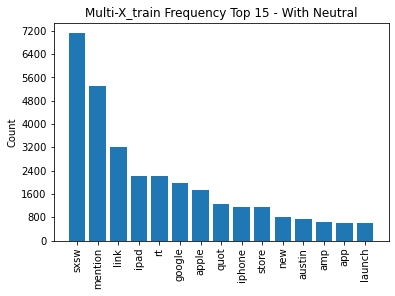

In [180]:
multi_train_freq_dist = FreqDist(multi_X_train['Tweet_tokens'].explode())
plot_frequency(multi_train_freq_dist, "Multi-X_train Frequency Top 15 - With Neutral")

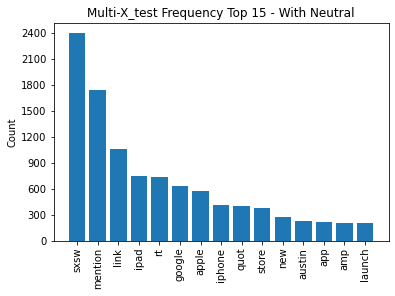

In [181]:
multi_test_freq_dist = FreqDist(multi_X_test['Tweet_tokens'].explode())
plot_frequency(multi_test_freq_dist, "Multi-X_test Frequency Top 15 - With Neutral")

### Count Vectorizer 
2500 Vocab was promising on the binary classification modeling.

### TF-IDF Vectorizer
Unrestricted Vocab and 835 restricted vocab was promising on the binary classification modeling.